In [1]:
# beem136_tb818_legal_aid_ew.ipynb
# Author: Thomas Burrows (tb818)
# Last edit: 02/12/2025, tb818

# SEE README FOR FULL DETAILS

# =====================================================================================
################## SECTION 1: CLEANING AND BALANCING PANELS ###########################
# =====================================================================================

# Cleans and balances panels required for analysis of civil legal aid provision in England and Wales.
# Datasets:
#   - Legal Aid Agency civil legal aid completions by provider area
#   - Census 2011 data for local authority districts in England and Wales (population, age, ethnicity, housing tenure, and economic activity)
#   - Census local authority district lookup data
#   - Converter from old to new local authority district codes
#   - Inflation data from ONS to convert nominal values to real terms (CPIH)
#   - Rurality index for local authorities

# Returns: full_panel.csv - cleaned and merged panel dataset for analysis

# SECTIONS:
# 1(A) - Initial setup, packages and data loading
# 1(B) - Initial panel construction
# 1(C) - Census data added
# 1(D) - Additional data added and panel saved

# ============================== Setup =========================================
from pathlib import Path                        # For easier path reading
import pandas as pd                             # For data manipulation
import numpy as np                              # For numerical operations
import geopandas as gpd                         # For geospatial data manipulation
import matplotlib.pyplot as plt                 # For plotting
import seaborn as sns                           # For enhanced visualisations
import matplotlib as mpl                        # For custom plotting
import matplotlib.colors as mcolors             # For custom colour maps
import matplotlib.patches as mpatches           # For construction of data legends
import sys                                      # For functional commands
import statsmodels.api as sm                    # For regressions
import statsmodels.formula.api as smf           # For regressions

# ================================== 1(A) SETUP ==================================
# --- PATH SETUP --- EDIT HERE ONLY
project_root = Path("C:/Users/tb818/OneDrive - University of Exeter/Documents/MRes Year 1/BEEM136 - Research Methods/legal_aid")

# Do not edit from below - sub-paths standardised with / for cross-platform compatibility
raw_files_inputs = Path(project_root/"raw_data")
cleaned_files_outputs = Path(project_root/"cleaned_data")
summary_stats = Path(project_root/"graphics/summary_stats")
time_series = Path(project_root/"graphics/time_series")
unique_providers_maps = Path(project_root/"graphics/unique_providers_maps")
deserts_maps = Path(project_root/"graphics/deserts_maps")
violin_dist = Path(project_root/"graphics/violins")
regression_outputs = Path(project_root/"regressions")

# Loads raw data
print("Loading data...")
provider_data_raw = pd.read_csv(raw_files_inputs / "legal-aid-statistics-civil-completions-provider-area-data-to-mar-2024.csv")

# To inspect raw data
# print(provider_data_completed_raw.info())

# ================================== 1(B) INITIAL PANEL CONSTRUCTION ==================================
# Constructs the panel by work completed
# Outputs by LA x quarter: total volume of cases, total value of cases, and total unique providers

# QUARTER MAPPING
# For conversion of financial year to calendar years
FQ_TO_CAL_Q = {1: 2, 2: 3, 3: 4, 4: 1}

# --- INITIAL CLEANING ---
print("Cleaning data...")
clean_data = (
    provider_data_raw
      # Keeping only needed columns; improves code efficiency
      [["VOL", "Total Value", "Fin_YR", "FIN_QTR", "LACode", "firm_code"]]
      .rename(
          columns={
              "VOL": "volume",
              "Total Value": "value",
              "Fin_YR": "fy",
              "FIN_QTR": "fq",
              "LACode": "lacode"}))

# Vectorised cleaning using Pandas - value, years and quarters cleaned to numeric
clean_data["value"] = pd.to_numeric(clean_data["value"], errors="coerce")
clean_data["fy_start"] = pd.to_numeric(clean_data["fy"].astype(str).str[:4], errors="coerce")
clean_data["fq"] = pd.to_numeric(clean_data["fq"], errors="coerce")

# Conversion of financial to calendar year
cal_q = clean_data["fq"].map(FQ_TO_CAL_Q)
cal_year = clean_data["fy_start"] + (clean_data["fq"] == 4).astype(int)
clean_data["year_quarter"] = cal_year.astype(int).astype(str) + "-q" + cal_q.astype(int).astype(str)

# --- LA × QUARTER TOTALS ---
print("Computing LA totals...")
# Aggregates totals for local authorities, by year_quarter
completed_la_totals = (
    clean_data
      .groupby(["year_quarter", "lacode"], as_index=False)
      .agg(
          la_total_volume=("volume", "sum"),
          la_total_value=("value", "sum"),
          unique_providers=("firm_code", "nunique")))

# --- NATIONAL TOTALS PER QUARTER ---
print("Computing national totals...")
# Aggregates totals by year_quarter only (i.e. national totals)
quarterly_totals = (
    clean_data
      .groupby("year_quarter", as_index=False)
      .agg(
          total_volume=("volume", "sum"),
          total_value=("value", "sum"),
          total_unique_providers=("firm_code", "nunique")))

# --- LA LOOKUP (E & W only) ---
print("Loading LA lookup file...")
# Ensuring all local authorities codes contained using authoritative guide
la_lookup = pd.read_csv(
    raw_files_inputs / "Local_Authority_District_(2022)_to_Local_Authority_District_(2023)_Lookup_for_EW.csv")

# Filtering ONS lookup to only England and Wales to fit with scope of panel
print("Filtering to England and Wales...")
la_lookup_filtered = (
    la_lookup
      .loc[la_lookup["LAD23CD"].str.startswith(("E", "W")), ["LAD23CD", "LAD23NM"]]
      .drop_duplicates(subset="LAD23CD")
      .rename(columns={"LAD23CD": "lacode", "LAD23NM": "localauthority"})
      .reset_index(drop=True))

# --- BALANCED PANEL INDEX ---
print("Constructing empty panel...")
# To balance, an empty LACODE*YR_QTR panel is created as a blank panel, filled with available data,
# and then 0 imputed for missing data
all_quarters = (
    completed_la_totals["year_quarter"]
      .astype(str)
      .sort_values()
      .unique())

all_las = (
    la_lookup_filtered["lacode"]
      .astype(str)
      .sort_values()
      .unique())

# The complete (empty) panel
idx = pd.MultiIndex.from_product(
    [all_quarters, all_las],
    names=["year_quarter", "lacode"])

balanced_panel = (
    completed_la_totals
      .set_index(["year_quarter", "lacode"])
      .reindex(idx)
      .reset_index())

# Filling missing aggregates with zero
balanced_panel[["la_total_volume", "la_total_value", "unique_providers"]] = (
    balanced_panel[["la_total_volume", "la_total_value", "unique_providers"]].fillna(0))

# Merging LA names
balanced_panel = balanced_panel.merge(
    la_lookup_filtered,
    on="lacode",
    how="left")

# Merging quarterly totals
balanced_panel = balanced_panel.merge(
    quarterly_totals,
    on="year_quarter",
    how="left")

# Trimming data from 2010-Q1 to 2019-Q4
balanced_panel = balanced_panel.loc[
    (balanced_panel["year_quarter"] >= "2010-q1")
    & (balanced_panel["year_quarter"] <= "2019-q4")
].reset_index(drop=True)

# ================================== 1(C) CENSUS DATA ADDED ==================================
# This section cleans the 5 census datasets for use in analysis
# Each cleaning process is analogous, so only population is fully commented
# Where additional notes are necessary, these are provided in-line

# Builds a dictionary for code mapping, old to new
print("Loading census data...")
converter = pd.read_csv(raw_files_inputs / "census_la_converter.csv")
code_map = dict(zip(converter["Old"], converter["New"]))

# POPULATION
# Reading raw population data
census_raw_population = pd.read_csv(raw_files_inputs / "raw_census_2011_populations.csv")

# Initial cleaning function
print("Cleaning population data...")
census_clean_population = (
    census_raw_population
    # renaming geography code to lacode for consistency
    .rename(columns={"geography code": "lacode"})
    # Dropping unneeded columns
    .drop(columns=[
        "date",
        "geography",
        "Rural Urban",
        "Variable: Area (Hectares); measures: Value",
        "Variable: Density (number of persons per hectare); measures: Value",
        "Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value"]))
# Any relevant LA codes mapped to new codes
census_clean_population["lacode"] = census_clean_population["lacode"].replace(code_map)

# Selecting target columns
target_cols_pop = [
  "Variable: All usual residents; measures: Value",
  "Variable: Males; measures: Value",
  "Variable: Females; measures: Value",
  "Variable: Lives in a household; measures: Value",
  "Variable: Lives in a communal establishment; measures: Value"]

# Filtering to target columns only (and lacode)
census_clean_population = census_clean_population.loc[:, ["lacode"] + target_cols_pop].rename(columns={
    "Variable: All usual residents; measures: Value": "residents_total",
    "Variable: Males; measures: Value": "males_total",
    "Variable: Females; measures: Value": "females_total",
    "Variable: Lives in a household; measures: Value": "household_dwellers",
    "Variable: Lives in a communal establishment; measures: Value": "communal_dwellers"})

# Aggregates for updated LAs
census_clean_population = census_clean_population.groupby("lacode", as_index=False).sum(numeric_only=True)

# AGES
census_raw_ages = pd.read_csv(raw_files_inputs / "raw_census_2011_ages.csv")

print("Cleaning age data...")
census_clean_age = (
    census_raw_ages
    .rename(columns={"geography code": "lacode"})
    .drop(columns=[
        "date",
        "geography",
        "Rural Urban",
        "Age: All usual residents; measures: Value",
        "Age: Mean Age; measures: Value",
        "Age: Median Age; measures: Value"]))
census_clean_age["lacode"] = census_clean_age["lacode"].replace(code_map)

target_cols_age = [
  "Age: Age 0 to 4; measures: Value",
  "Age: Age 5 to 7; measures: Value",
  "Age: Age 8 to 9; measures: Value",
  "Age: Age 10 to 14; measures: Value",
  "Age: Age 15; measures: Value",
  "Age: Age 16 to 17; measures: Value",
  "Age: Age 18 to 19; measures: Value",
  "Age: Age 20 to 24; measures: Value",
  "Age: Age 25 to 29; measures: Value",
  "Age: Age 30 to 44; measures: Value",
  "Age: Age 45 to 59; measures: Value",
  "Age: Age 60 to 64; measures: Value",
  "Age: Age 65 to 74; measures: Value",
  "Age: Age 75 to 84; measures: Value",
  "Age: Age 85 to 89; measures: Value",
  "Age: Age 90 and over; measures: Value"]

census_clean_age = census_clean_age.loc[:,["lacode"] + target_cols_age].rename(columns={
    "Age: Age 0 to 4; measures: Value": "total_0_4",
    "Age: Age 5 to 7; measures: Value": "total_5_7",
    "Age: Age 8 to 9; measures: Value": "total_8_9",
    "Age: Age 10 to 14; measures: Value": "total_10_14",
    "Age: Age 15; measures: Value": "total_15",
    "Age: Age 16 to 17; measures: Value": "total_16_17",
    "Age: Age 18 to 19; measures: Value": "total_18_19",
    "Age: Age 20 to 24; measures: Value": "total_20_24",
    "Age: Age 25 to 29; measures: Value": "total_25_29",
    "Age: Age 30 to 44; measures: Value": "total_30_44",
    "Age: Age 45 to 59; measures: Value": "total_45_59",
    "Age: Age 60 to 64; measures: Value": "total_60_64",
    "Age: Age 65 to 74; measures: Value": "total_65_74",
    "Age: Age 75 to 84; measures: Value": "total_75_84",
    "Age: Age 85 to 89; measures: Value": "total_85_89",
    "Age: Age 90 and over; measures: Value": "total_90_over"})

census_clean_age = census_clean_age.groupby("lacode", as_index=False).sum(numeric_only=True)

# Constructing age groupings for analysis
census_clean_age = census_clean_age.assign(
    working_age = census_clean_age[[
        "total_16_17","total_18_19","total_20_24","total_25_29",
        "total_30_44","total_45_59","total_60_64","total_65_74"
    ]].sum(axis=1, min_count=1),
    children = census_clean_age[[
        "total_0_4","total_5_7","total_8_9","total_10_14","total_15"
    ]].sum(axis=1, min_count=1),
    pensioner = census_clean_age[[
        "total_75_84","total_85_89","total_90_over"
    ]].sum(axis=1, min_count=1))

# EMPLOYMENT
census_raw_employment = pd.read_csv(raw_files_inputs / "raw_census_2011_economic_activity.csv")

print("Cleaning employment data...")
census_clean_employment = (
    census_raw_employment
    .rename(columns={"geography code": "lacode"})
    .drop(columns=[
        "date",
        "geography",
        "Economic Activity: All usual residents aged 16 to 74; measures: Value"]))
census_clean_employment["lacode"] = census_clean_employment["lacode"].replace(code_map)

# N.B. Filtering to England and Wales only. Not necessary for all census datasets (not all available at same level of analysis)
census_clean_employment = census_clean_employment[census_clean_employment["lacode"].str.startswith(("E","W"))]

target_cols_employment = [
  "Economic Activity: Economically active; measures: Value",
  "Economic Activity: Economically active: In employment; measures: Value",
  "Economic Activity: Economically active: Employee: Part-time; measures: Value",
  "Economic Activity: Economically active: Employee: Full-time; measures: Value",
  "Economic Activity: Economically active: Self-employed; measures: Value",
  "Economic Activity: Economically active: Unemployed; measures: Value",
  "Economic Activity: Economically active: Full-time student; measures: Value",
  "Economic Activity: Economically Inactive; measures: Value",
  "Economic Activity: Economically inactive: Retired; measures: Value",
  "Economic Activity: Economically inactive: Student (including full-time students); measures: Value",
  "Economic Activity: Economically inactive: Looking after home or family; measures: Value",
  "Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value",
  "Economic Activity: Economically inactive: Other; measures: Value",
  "Economic Activity: Unemployed: Age 16 to 24; measures: Value",
  "Economic Activity: Unemployed: Age 50 to 74; measures: Value",
  "Economic Activity: Unemployed: Never worked; measures: Value",
  "Economic Activity: Long-term unemployed; measures: Value"]

census_clean_employment = census_clean_employment.loc[:, ["lacode"] + target_cols_employment].rename(columns={
    "Economic Activity: Economically active; measures: Value": "econ_active",
    "Economic Activity: Economically active: In employment; measures: Value": "a_employed",
    "Economic Activity: Economically active: Employee: Part-time; measures: Value": "a_part_time",
    "Economic Activity: Economically active: Employee: Full-time; measures: Value": "a_full_time",
    "Economic Activity: Economically active: Self-employed; measures: Value": "a_self_employed",
    "Economic Activity: Economically active: Unemployed; measures: Value": "a_unemployed",
    "Economic Activity: Economically active: Full-time student; measures: Value": "a_student",
    "Economic Activity: Economically Inactive; measures: Value": "econ_inactive",
    "Economic Activity: Economically inactive: Retired; measures: Value": "ia_retired",
    "Economic Activity: Economically inactive: Student (including full-time students); measures: Value": "ia_student",
    "Economic Activity: Economically inactive: Looking after home or family; measures: Value": "ia_carer",
    "Economic Activity: Economically inactive: Long-term sick or disabled; measures: Value": "ia_sick_disb",
    "Economic Activity: Economically inactive: Other; measures: Value": "ina_other",
    "Economic Activity: Unemployed: Age 16 to 24; measures: Value": "unemployed_16_24",
    "Economic Activity: Unemployed: Age 50 to 74; measures: Value": "unemployed_50_74",
    "Economic Activity: Unemployed: Never worked; measures: Value": "unemployed_forever",
    "Economic Activity: Long-term unemployed; measures: Value": "unemployed_lt"})

census_clean_employment = census_clean_employment.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating unemployment rate
census_clean_employment["unemployment_rate"] = census_clean_employment["a_unemployed"] / census_clean_employment["econ_active"]

# HOUSING
census_raw_tenure = pd.read_csv(raw_files_inputs / "raw_census_2011_housing_tenure.csv")

print("Cleaning housing data...")
census_clean_tenure = (
    census_raw_tenure
    .rename(columns={"geography code": "lacode"})
    .drop(columns=["date", "geography", "Rural Urban"]))
census_clean_tenure["lacode"] = census_clean_tenure["lacode"].replace(code_map)
census_clean_tenure = census_clean_tenure[census_clean_tenure["lacode"].str.startswith(("E","W"))]

target_cols_tenure = [
  "Tenure: All households; measures: Value",
  "Tenure: Owned; measures: Value",
  "Tenure: Owned: Owned outright; measures: Value",
  "Tenure: Owned: Owned with a mortgage or loan; measures: Value",
  "Tenure: Shared ownership (part owned and part rented); measures: Value",
  "Tenure: Social rented; measures: Value",
  "Tenure: Social rented: Rented from council (Local Authority); measures: Value",
  "Tenure: Social rented: Other; measures: Value",
  "Tenure: Private rented; measures: Value",
  "Tenure: Private rented: Private landlord or letting agency; measures: Value",
  "Tenure: Private rented: Other; measures: Value",
  "Tenure: Living rent free; measures: Value"]

census_clean_tenure = census_clean_tenure.loc[:, ["lacode"] + target_cols_tenure].rename(columns={
    "Tenure: All households; measures: Value": "households",
    "Tenure: Owned; measures: Value": "hh_owned",
    "Tenure: Owned: Owned outright; measures: Value": "hh_owned_outright",
    "Tenure: Owned: Owned with a mortgage or loan; measures: Value": "hh_owned_mortgaged",
    "Tenure: Shared ownership (part owned and part rented); measures: Value": "hh_shared_own",
    "Tenure: Social rented; measures: Value": "hh_social_rented",
    "Tenure: Social rented: Rented from council (Local Authority); measures: Value": "hh_social_rented_council",
    "Tenure: Social rented: Other; measures: Value": "hh_social_rented_other",
    "Tenure: Private rented; measures: Value": "hh_private_rented",
    "Tenure: Private rented: Private landlord or letting agency; measures: Value": "hh_private_rented_landlord",
    "Tenure: Private rented: Other; measures: Value": "hh_private_rented_other",
    "Tenure: Living rent free; measures: Value": "hh_rent_free"})
census_clean_tenure = census_clean_tenure.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating proportions
census_clean_tenure = census_clean_tenure.assign(
    prop_hh_owned = census_clean_tenure["hh_owned"] / census_clean_tenure["households"],
    prop_hh_social_rented = census_clean_tenure["hh_social_rented"] / census_clean_tenure["households"],
    prop_hh_private_rented = census_clean_tenure["hh_private_rented"] / census_clean_tenure["households"],
    prop_hh_rented = (census_clean_tenure["hh_social_rented"] + census_clean_tenure["hh_private_rented"]) / census_clean_tenure["households"])

# ETHNICITY
census_raw_ethnicity = pd.read_csv(raw_files_inputs / "raw_census_2011_ethnicity.csv")

print("Cleaning ethnicity data...")
census_clean_ethnicity = (
    census_raw_ethnicity
    .rename(columns={"geography code": "lacode"})
    .drop(columns=["date","geography","Rural Urban"]))
census_clean_ethnicity["lacode"] = census_clean_ethnicity["lacode"].replace(code_map)
census_clean_ethnicity = census_clean_ethnicity[census_clean_ethnicity["lacode"].str.startswith(("E","W"))]

target_cols_ethnicity = [
  "Ethnic Group: All usual residents; measures: Value",
  "Ethnic Group: White; measures: Value",
  "Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value",
  "Ethnic Group: White: Irish; measures: Value",
  "Ethnic Group: White: Gypsy or Irish Traveller; measures: Value",
  "Ethnic Group: White: Other White; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value",
  "Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value",
  "Ethnic Group: Asian/Asian British; measures: Value",
  "Ethnic Group: Asian/Asian British: Indian; measures: Value",
  "Ethnic Group: Asian/Asian British: Pakistani; measures: Value",
  "Ethnic Group: Asian/Asian British: Bangladeshi; measures: Value",
  "Ethnic Group: Asian/Asian British: Chinese; measures: Value",
  "Ethnic Group: Asian/Asian British: Other Asian; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: African; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: Caribbean; measures: Value",
  "Ethnic Group: Black/African/Caribbean/Black British: Other Black; measures: Value",
  "Ethnic Group: Other ethnic group; measures: Value",
  "Ethnic Group: Other ethnic group: Arab; measures: Value",
  "Ethnic Group: Other ethnic group: Any other ethnic group; measures: Value"]

census_clean_ethnicity = census_clean_ethnicity.loc[:, ["lacode"] + target_cols_ethnicity].rename(columns={
    "Ethnic Group: All usual residents; measures: Value": "residents",
    "Ethnic Group: White; measures: Value": "eth_white",
    "Ethnic Group: White: English/Welsh/Scottish/Northern Irish/British; measures: Value": "eth_white_brit",
    "Ethnic Group: White: Irish; measures: Value": "eth_white_irish",
    "Ethnic Group: White: Gypsy or Irish Traveller; measures: Value": "eth_white_trav",
    "Ethnic Group: White: Other White; measures: Value": "eth_white_other",
    "Ethnic Group: Mixed/multiple ethnic groups; measures: Value": "eth_mixed",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Black Caribbean; measures: Value": "eth_mixed_carrib",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Black African; measures: Value": "eth_mixed_afr",
    "Ethnic Group: Mixed/multiple ethnic groups: White and Asian; measures: Value": "eth_mixed_asian",
    "Ethnic Group: Mixed/multiple ethnic groups: Other Mixed; measures: Value": "eth_mixed_other",
    "Ethnic Group: Asian/Asian British; measures: Value": "eth_asian",
    "Ethnic Group: Asian/Asian British: Indian; measures: Value": "eth_asian_ind",
    "Ethnic Group: Asian/Asian British: Pakistani; measures: Value": "eth_asian_pak",
    "Ethnic Group: Asian/Asian British: Bangladeshi; measures: Value": "eth_asian_bang",
    "Ethnic Group: Asian/Asian British: Chinese; measures: Value": "eth_asian_chi",
    "Ethnic Group: Asian/Asian British: Other Asian; measures: Value": "eth_asian_other",
    "Ethnic Group: Black/African/Caribbean/Black British; measures: Value": "eth_black",
    "Ethnic Group: Black/African/Caribbean/Black British: African; measures: Value": "eth_black_afr",
    "Ethnic Group: Black/African/Caribbean/Black British: Caribbean; measures: Value": "eth_black_carrib",
    "Ethnic Group: Black/African/Caribbean/Black British: Other Black; measures: Value": "eth_black_other",
    "Ethnic Group: Other ethnic group; measures: Value": "eth_other",
    "Ethnic Group: Other ethnic group: Arab; measures: Value": "eth_other_arab",
    "Ethnic Group: Other ethnic group: Any other ethnic group; measures: Value": "eth_other_other"})
census_clean_ethnicity = census_clean_ethnicity.groupby("lacode", as_index=False).sum(numeric_only=True)

# Calculating proportions
census_clean_ethnicity = census_clean_ethnicity.assign(
    prop_eth_white = census_clean_ethnicity["eth_white"] / census_clean_ethnicity["residents"],
    prop_eth_mixed = census_clean_ethnicity["eth_mixed"] / census_clean_ethnicity["residents"],
    prop_eth_asian = census_clean_ethnicity["eth_asian"] / census_clean_ethnicity["residents"],
    prop_eth_black = census_clean_ethnicity["eth_black"] / census_clean_ethnicity["residents"],
    prop_eth_other = census_clean_ethnicity["eth_other"] / census_clean_ethnicity["residents"])

# COMBINED
print("Combining census data...")
census_data = (
    census_clean_population
    .merge(census_clean_age, on="lacode", how="outer")
    .merge(census_clean_employment, on="lacode", how="outer")
    .merge(census_clean_tenure, on="lacode", how="outer")
    .merge(census_clean_ethnicity, on="lacode", how="outer"))
census_data = census_data.loc[:, ~census_data.columns.duplicated(keep="first")]

# CENSUS DATA CHECKS
print("Checking census data...")
# Checking the union of LACODES with the panel:
codes_provider = set(balanced_panel["lacode"].astype("string"))
codes_census_population = set(census_clean_population["lacode"].astype("string"))
codes_census_age = set(census_clean_age["lacode"].astype("string"))
codes_census_employment = set(census_clean_employment["lacode"].astype("string"))
codes_census_tenure = set(census_clean_tenure["lacode"].astype("string"))
codes_census_ethnicity = set(census_clean_ethnicity["lacode"].astype("string"))
codes_census = set(census_data["lacode"].astype("string"))
all_equal = (
    codes_provider
    == codes_census_population
    == codes_census_age
    == codes_census_employment
    == codes_census_tenure
    == codes_census_ethnicity
    == codes_census)
print("All code sets identical across provider + all census tables:", all_equal)

# Checking for any missing values in the census data
missing_rows = census_data.isna().any(axis=1).sum()
print(f"Rows in census data with any missing values: {missing_rows} out of {len(census_data)}")

# Checking that all proportion columns are between 0 and 1
proportion_cols = [col for col in census_data.columns if col.startswith("prop_")]
for col in proportion_cols:
    if not ((census_data[col] >= 0) & (census_data[col] <= 1)).all():
        print(f"Proportion column {col} has values outside the range [0, 1].")
if not (census_data[unemployment_rate := "unemployment_rate"] >= 0).all() or not (census_data[unemployment_rate] <= 1).all():
    print(f"Proportion column {unemployment_rate} has values outside the range [0, 1].")

# Constructing the full panel by merging balanced_panel with census_data
print("Combining panel with census data...")
full_panel = balanced_panel.merge(census_data, on="lacode", how="left")

# ================================== 1(D) ADDITIONAL DATA ==================================
### ----- INFLATION ADJUSTMENT ----- ###
# Loading inflation data
print("Loading inflation data...")
inflation_data = pd.read_csv(raw_files_inputs / "inflation_data.csv")

# Merging inflation index onto full_panel (1:m by year_quarter)
full_panel = full_panel.merge(
    inflation_data[["year_quarter", "index_15"]],
    on="year_quarter",
    how="left")

# Checking inflation values for all time periods
missing_inf = full_panel.loc[full_panel["index_15"].isna(), "year_quarter"].unique()
print("Year_quarter values in full_panel missing inflation data:",missing_inf)

# Create adjusted value columns
full_panel["adjusted_la_total_value"] = (full_panel["la_total_value"] * full_panel["index_15"])
full_panel["adjusted_total_value"] = (full_panel["total_value"] * full_panel["index_15"])

# Creating volume-rval index (aggregate and per LA)
full_panel["val_vol"] = (full_panel["adjusted_total_value"] / full_panel["total_volume"])
full_panel["val_vol"] = full_panel["val_vol"].fillna(0)
full_panel["la_val_vol"] = (full_panel["adjusted_la_total_value"] / full_panel["la_total_volume"])
full_panel["la_val_vol"] = full_panel["la_val_vol"].fillna(0)

# Building rebased indices (2012-q4 = 100)
# This is the first period where LASPO reforms are fully in effect
full_panel["volume_index"] = (full_panel["total_volume"]/full_panel.loc[full_panel["year_quarter"] == "2012-q4", "total_volume"].iloc[0] * 100)
full_panel["value_index"] = (full_panel["adjusted_total_value"]/full_panel.loc[full_panel["year_quarter"] == "2012-q4", "adjusted_total_value"]
                        .iloc[0] * 100)
full_panel["cases_index"] = (full_panel["val_vol"] / full_panel.loc[full_panel["year_quarter"] == "2012-q4", "val_vol"]
                        .iloc[0] * 100)

full_panel["volume_index"] = full_panel["volume_index"].fillna(0)
full_panel["value_index"]  = full_panel["value_index"].fillna(0)
full_panel["cases_index"]  = full_panel["cases_index"].fillna(0)

### ----- PANEL-LEVEL DERIVED VARIABLES ----- ###
print("Constructing derived panel variables (logs, LASPO, deserts)...")

# Log transformations to capture levels, not values
full_panel["log_residents_total"] = np.log(full_panel["residents_total"])
full_panel["log_working_age"] = np.log(full_panel["working_age"])

# LASPO cutoff in this dataset
laspo_implemented = "2013-q1"

# Pre-LASPO values for exposure calculation
pre_laspo = full_panel[full_panel["year_quarter"] < laspo_implemented].copy()
pre_laspo["value_pc"] = pre_laspo["adjusted_la_total_value"] / pre_laspo["residents_total"]

# exposure_i: average pre-LASPO adjusted value per capita by LA
# How 'exposed' a local authority is to publically funded legal aid
exposure = pre_laspo.groupby("lacode")["value_pc"].mean()
exposure.name = "exposure"

# Merge exposure back to full_panel
full_panel = full_panel.merge(exposure, on="lacode", how="left")

# Post-LASPO indicator
# Dummy variable for post implementation
full_panel["post"] = (full_panel["year_quarter"] >= laspo_implemented).astype(int)

# Legal aid desert indicator: 1 if no providers in that LA-quarter
full_panel["desert"] = (full_panel["unique_providers"] == 0).astype(int)

# Constructing whether an LA is ever a desert in data
ever_desert = full_panel.groupby("lacode")["desert"].max().rename("ever_desert").reset_index()
full_panel = full_panel.merge(ever_desert, on="lacode", how="left")

# Legal aid deserts: proportion of local authorities and populations within them
prop_zero = (
    full_panel
      .groupby("year_quarter")["desert"]
      .mean()
      .reset_index(name="prop_zero"))

pop_zero = (
    full_panel.loc[full_panel["desert"] == 1]
      .groupby("year_quarter")["residents_total"]
      .sum()
      .reset_index(name="pop_zero"))

full_panel = full_panel.merge(prop_zero, on="year_quarter", how="left")
full_panel = full_panel.merge(pop_zero, on="year_quarter", how="left")

### ----- ADDING URBAN-RURAL CLASSIFICATION ----- ###
rural_urban = pd.read_csv(raw_files_inputs/"rural_urban_categories.csv")
full_panel = full_panel.merge(rural_urban[["LAD23CD", "rural_code"]], left_on="lacode", right_on="LAD23CD", how="left")
full_panel["is_rural"] = full_panel["rural_code"].str.startswith("R").astype(int)

# Final data check
if full_panel.isna().any().any():
    print("NAs detected")
else:
    print("No NAs in panel.")

# SAVING
full_panel.to_csv(cleaned_files_outputs / "full_panel.csv", index=False)
print("Panel saved to full_panel.csv")

Loading data...


C:\Users\tb818\AppData\Local\Temp\ipykernel_10980\1670698182.py:58: DtypeWarning: Columns (7,8,10,25) have mixed types. Specify dtype option on import or set low_memory=False.
  provider_data_raw = pd.read_csv(raw_files_inputs / "legal-aid-statistics-civil-completions-provider-area-data-to-mar-2024.csv")


Cleaning data...
Computing LA totals...
Computing national totals...
Loading LA lookup file...
Filtering to England and Wales...
Constructing empty panel...
Loading census data...
Cleaning population data...
Cleaning age data...
Cleaning employment data...
Cleaning housing data...
Cleaning ethnicity data...
Combining census data...
Checking census data...
All code sets identical across provider + all census tables: True
Rows in census data with any missing values: 0 out of 318
Combining panel with census data...
Loading inflation data...
Year_quarter values in full_panel missing inflation data: []
Constructing derived panel variables (logs, LASPO, deserts)...
No NAs in panel.
Panel saved to full_panel.csv


                                  mean        median
adjusted_la_total_value  337219.656230  260198.65361
la_total_volume             180.300884     118.00000
unique_providers              5.363067       5.00000
Time series graphs completed.
All maps and legend scale saved.
All desert maps and legend saved.
Violins saved.


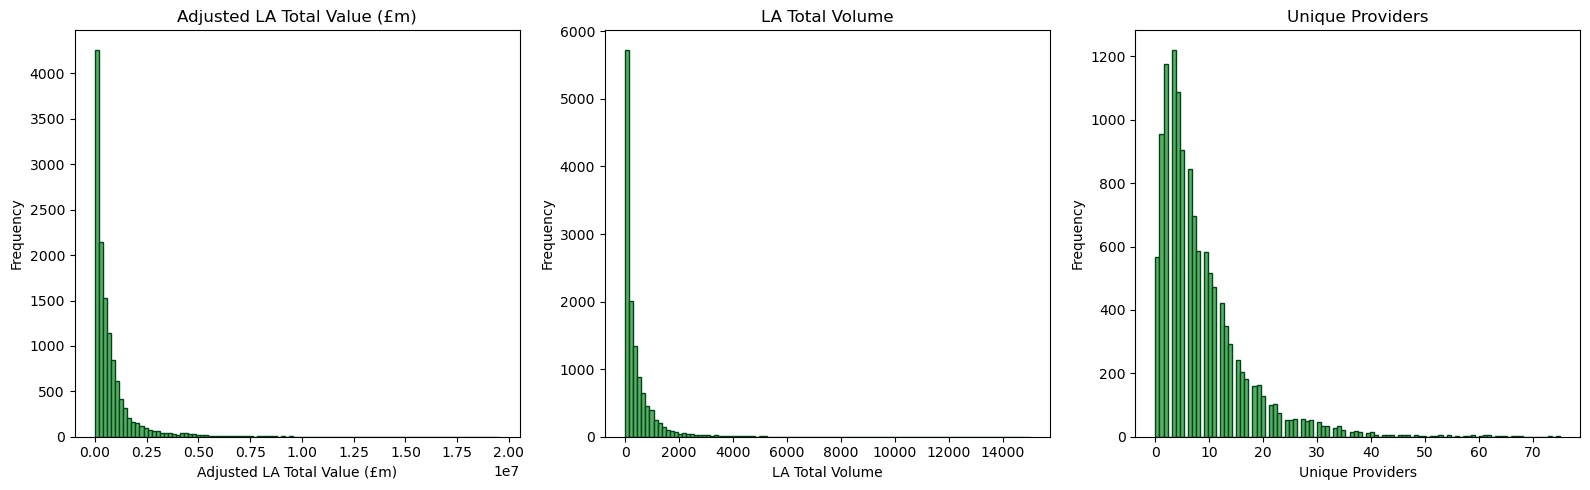

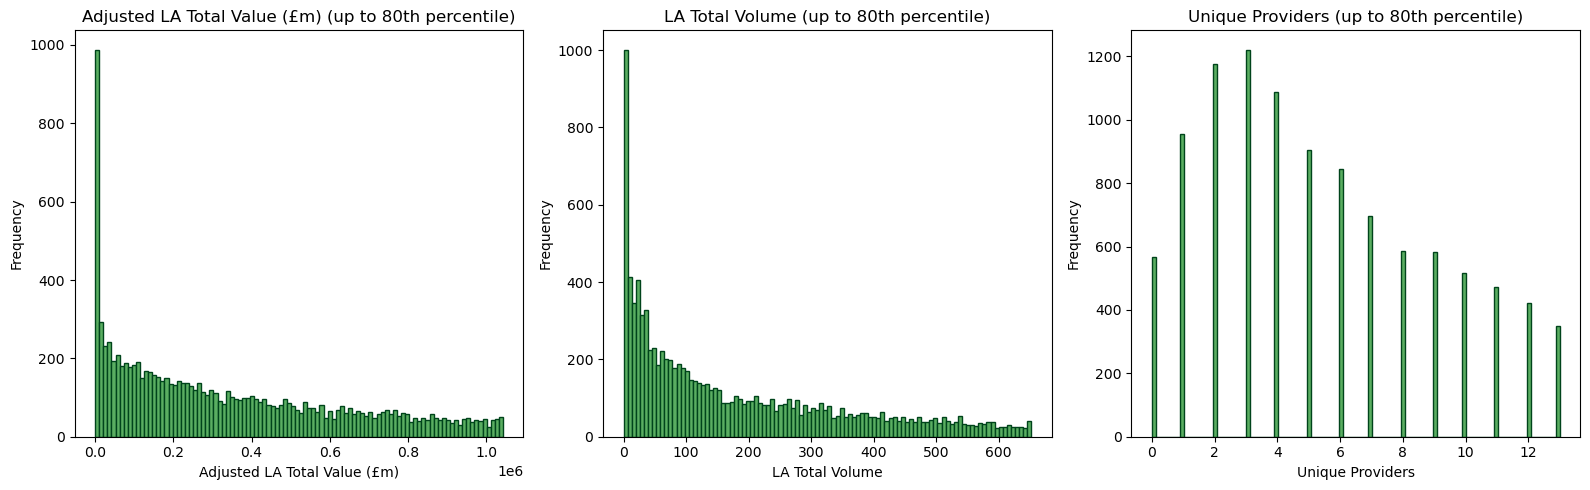

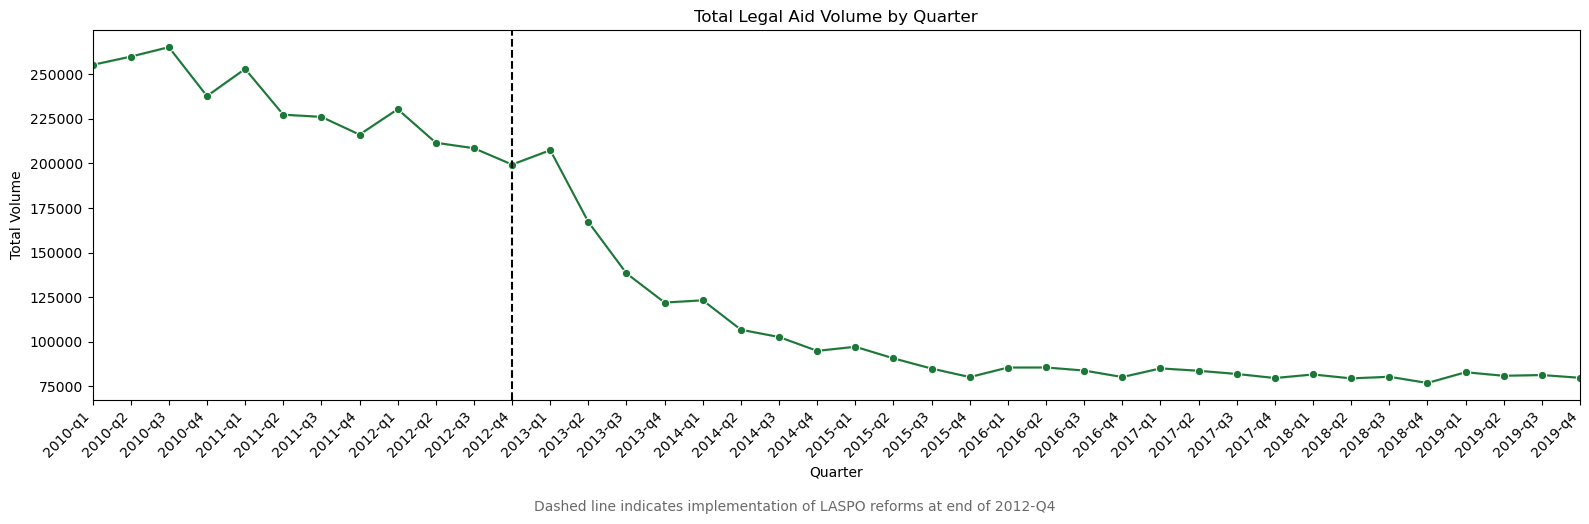

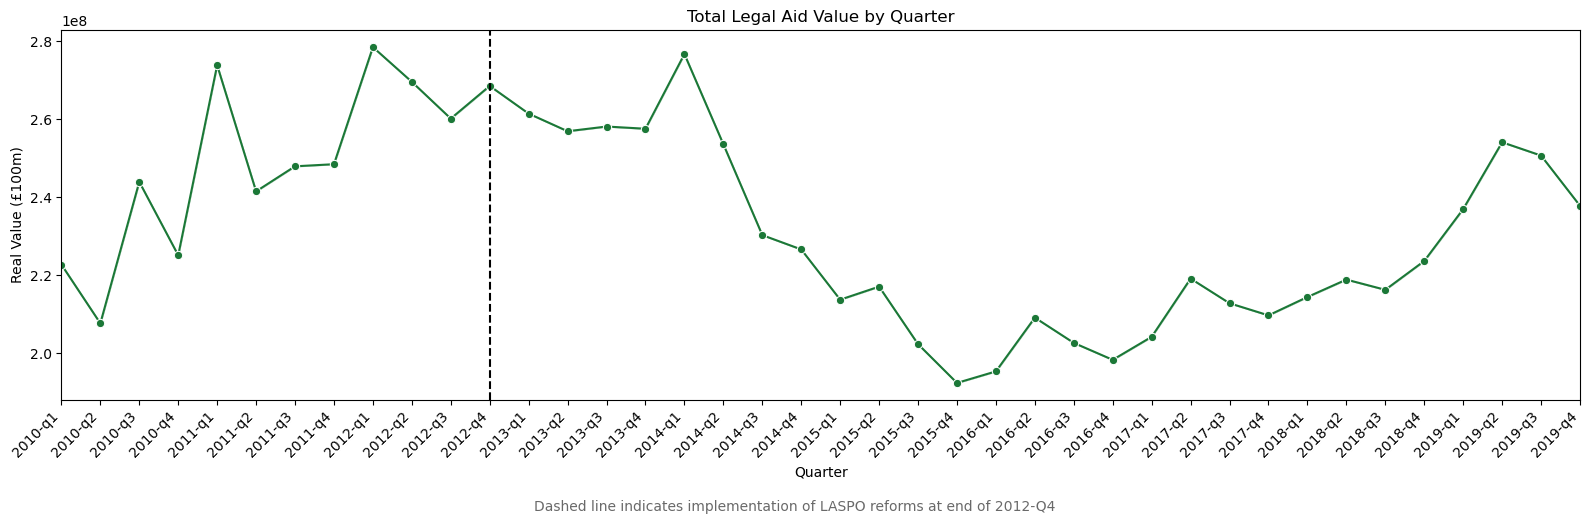

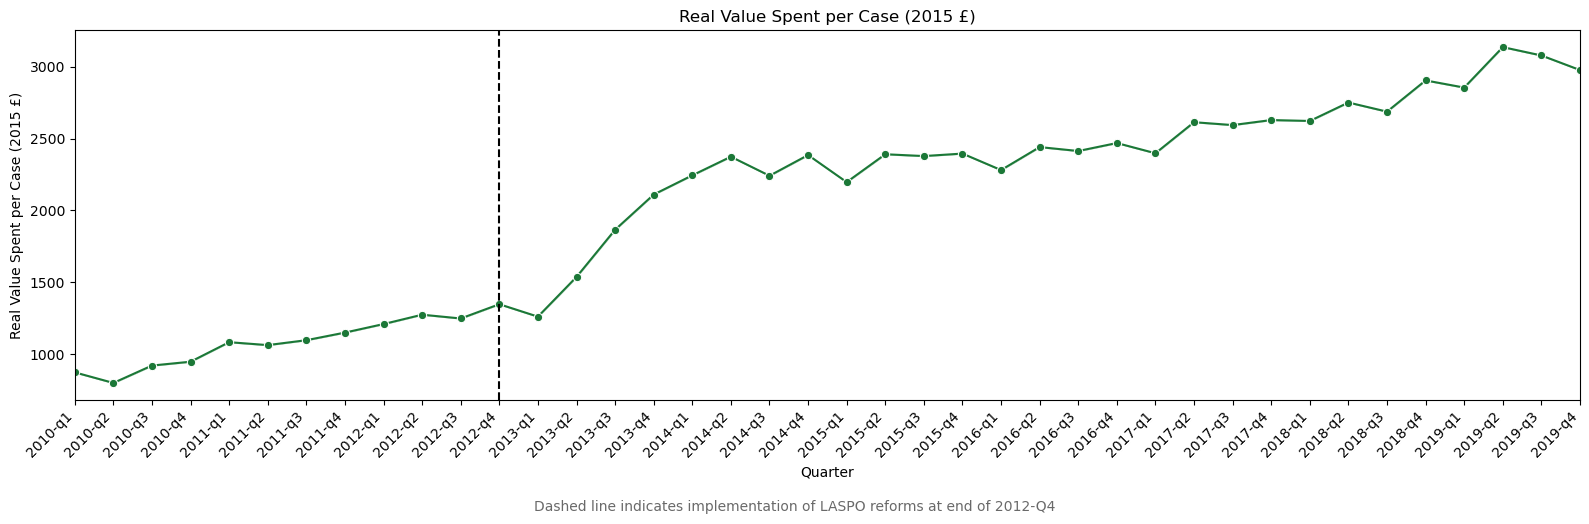

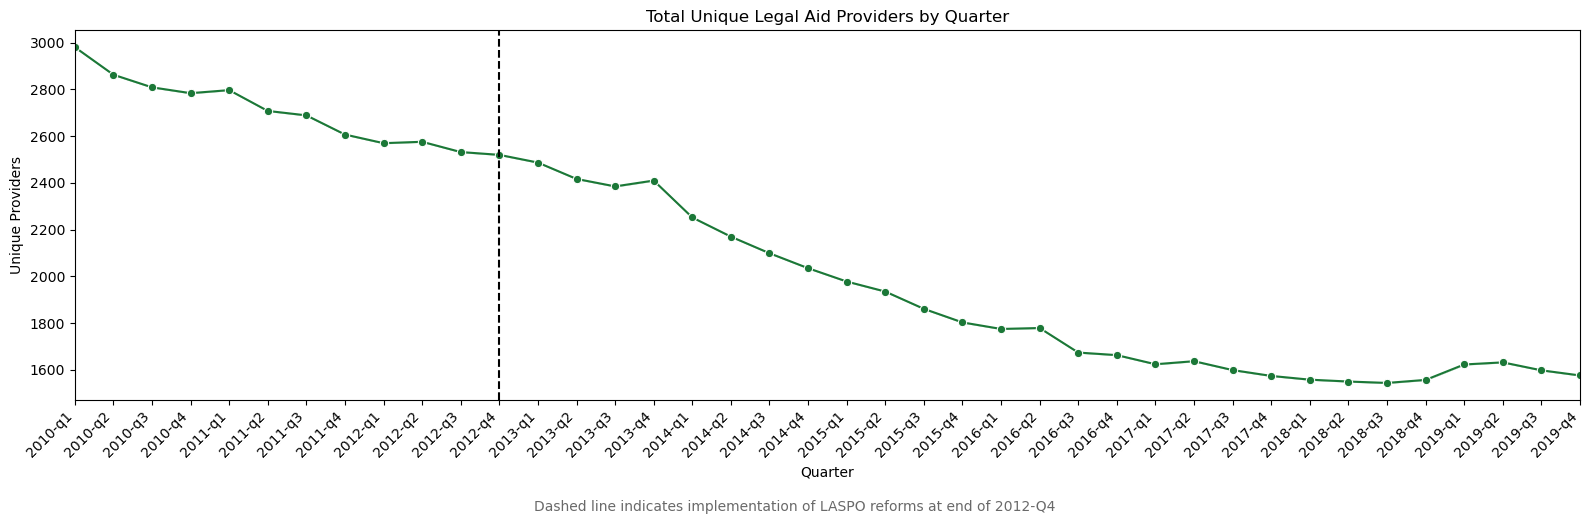

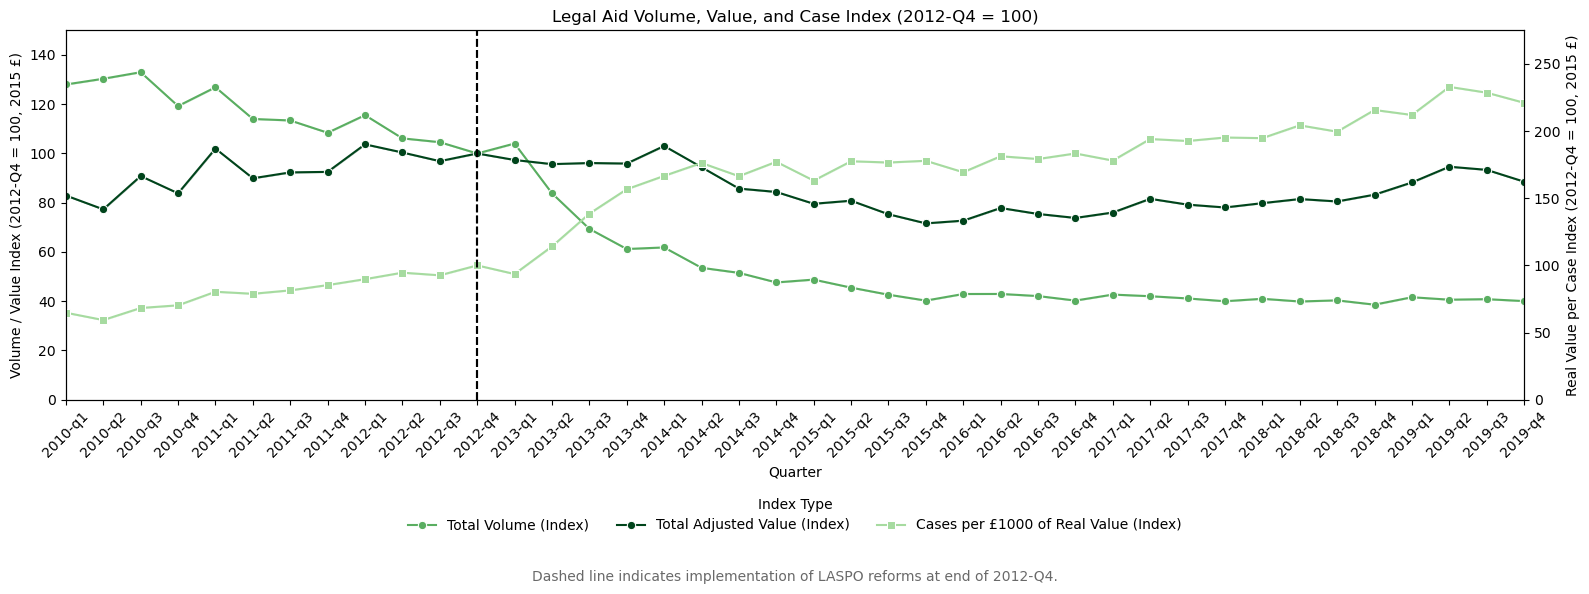

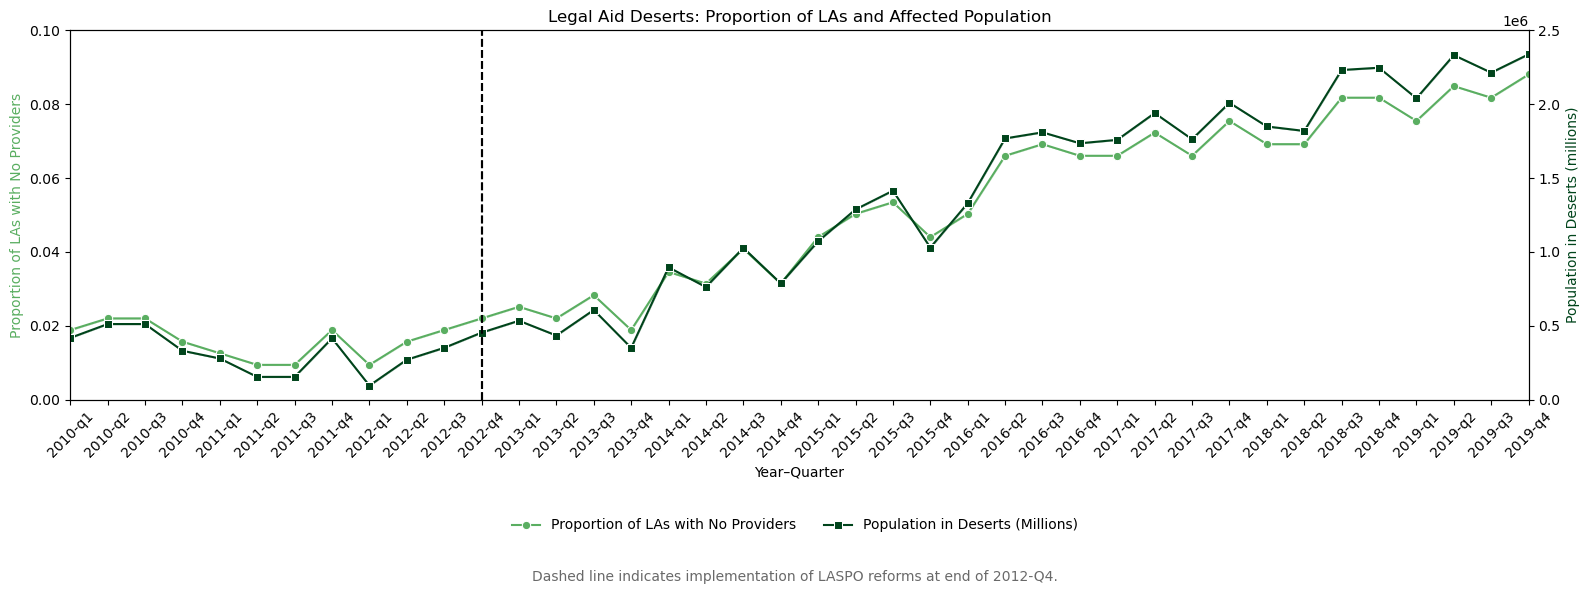

In [ ]:
# =====================================================================================
############# SECTION 2: SUMMARY STATISTICS AND DATA VISUALISATION ####################
# =====================================================================================
# This section displays summary statistics for the cleaned data and creates visualisations of legal aid provision trends over time

# SECTIONS:
# 2(A) - Summary Statistics
# 2(B) - Time Series
# 2(C) - Maps
# 2(D) - Violin Distributions

# NOTE: this code assumes that the provider panel has already been cleaned and saved as full_panel.csv
# Whilst this section can be run independently of most of Section 1, running Section 1a is required for used packages

# Loading cleaned provider panel data as vs_panel for clarity that it is being used for visualisation
vs_panel = pd.read_csv(cleaned_files_outputs/"full_panel.csv")

# Standardised colour setup dictionary
exeter_greens = {
    "light": "#d9f0d3",
    "light_medium": "#a6dba0",
    "medium": "#5aae61",
    "medium_dark": "#1b7837",
    "dark": "#00441b"}

### ------------------------------------- 2(A): SUMMARY STATISTICS ------------------------------------###
# Key variables of interest
cols = ["adjusted_la_total_value", "la_total_volume", "unique_providers"]
titles = ["Adjusted LA Total Value (£m)", "LA Total Volume", "Unique Providers"]

# Using matplotlib to plot distributions of value, volume and unique provider counts
# They are then saved to the same PDF
plt.figure(figsize=(16, 5))
for i, (col, title) in enumerate(zip(cols, titles), start=1):
    plt.subplot(1, 3, i)
    plt.hist(vs_panel[col], bins=100, color=exeter_greens["medium"], edgecolor=exeter_greens["dark"])
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(summary_stats / "val_vol_providers_dist.pdf", bbox_inches="tight", transparent=True, format="pdf")

# As data strongly positively skewed, displaying only first 80%
# Computing trimmed versions per variable for this range
trimmed = {}
for col in cols:
    cutoff = vs_panel[col].quantile(0.8)
    trimmed[col] = vs_panel.loc[vs_panel[col] <= cutoff, col]

# Plotting histograms and saving
plt.figure(figsize=(16, 5))
for i, (col, title) in enumerate(zip(cols, titles), start=1):
    plt.subplot(1, 3, i)
    plt.hist(trimmed[col], bins=100, color=exeter_greens["medium"], edgecolor=exeter_greens["dark"])
    plt.title(f"{title} (up to 80th percentile)")
    plt.xlabel(title)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(summary_stats / "val_vol_providers_dist_80pc.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ------------------------------------------ SECTION 2B: TIME SERIES ------------------------------------------------ ###
### ----- Total Legal Aid Volume by Quarter ----- ###
# Plotting time series of volume, value, index of cases per £1000, and unique firm count to see patterns in data
# Using seaborn/matplotlib. All plots equivalently generated; only first commented for explanation
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="total_volume",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Legal Aid Volume by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Total Volume")
plt.xticks(rotation=45, ha="right")

# Add vertical line at period of LASPO implementation
# NOTE: whilst implemented in 2012-q4, first period of impact 2013-q1, hence different
# to recording in panel for statistical purposes
plt.axvline(x="2012-q4", linestyle="--", color="black")

# Limiting x-axis to actual data range (aesthetic)
x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

# LASPO line caption
plt.figtext(0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "vol_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ----- Total Legal Aid Value by Quarter ----- ###
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="adjusted_total_value",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Legal Aid Value by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Real Value (£100m)")
plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "adj_val_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ----- Total Value/Volume Index by Quarter ----- ###
plt.figure(figsize=(16, 5))

sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="val_vol",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Real Value Spent per Case (2015 £)")
plt.xlabel("Quarter")
plt.ylabel("Real Value Spent per Case (2015 £)")
plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "val_vol_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ----- Unique Firms by Quarter ----- ###
plt.figure(figsize=(16, 5))
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="total_unique_providers",
    marker="o",
    color=exeter_greens["medium_dark"])

plt.title("Total Unique Legal Aid Providers by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Unique Providers")

plt.xticks(rotation=45, ha="right")

plt.axvline(x="2012-q4", linestyle="--", color="black")

x_values = vs_panel["year_quarter"].unique()
plt.xlim(x_values.min(), x_values.max())

plt.figtext(
    0.5, -0.01,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4",
    ha="center", va="top", fontsize=10, color="dimgray")

plt.tight_layout()
plt.savefig(time_series / "unique_firms_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ----- Total Legal Aid Indices by Quarter ----- ###
fig, ax1 = plt.subplots(figsize=(16, 5))
ax2 = ax1.twinx()

# Plotting: Volume
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="volume_index",
    marker="o",
    color=exeter_greens["medium"],
    label="Total Volume (Index)",
    ax=ax1)

# Plotting: Value
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="value_index",
    marker="o",
    color=exeter_greens["dark"],
    label="Total Adjusted Value (Index)",
    ax=ax1)

# Plotting: Cases
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="cases_index",
    marker="s",
    color=exeter_greens["light_medium"],
    label="Cases per £1000 of Real Value (Index)",
    ax=ax2)

# Left y-axis (0–150): Scale for Total Volume and Total Adjusted Value
ax1.set_ylabel("Volume / Value Index (2012-Q4 = 100, 2015 £)")
ax1.set_ylim(0, 150)
ax1.set_xlabel("Quarter")
ax1.tick_params(axis="x", rotation=45)

# Right y-axis (0–275): Scale for Real Value per Case
ax2.set_ylabel("Real Value per Case Index (2012-Q4 = 100, 2015 £)")
ax2.set_ylim(0, 275)

# Matching x-axis to data range
x_values = vs_panel["year_quarter"].unique()
ax1.set_xlim(x_values.min(), x_values.max())

# LASPO vertical line
for ax in [ax1, ax2]:
    ax.axvline(x="2012-q4", linestyle="--", color="black")

# Removing legends from individual axes (aesthetic)
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Combined legend below (aesthetic)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower center",
    ncol=3,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1),
    title="Index Type")

# Title and caption
plt.title("Legal Aid Volume, Value, and Case Index (2012-Q4 = 100)")
fig.text(
    0.5,
    -0.15,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4.",
    ha="center",
    va="top",
    fontsize=10,
    color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "val_vol_cases_indexes_by_qtr.pdf", bbox_inches="tight", transparent=True, format="pdf")

### ----- Total Proportion of and Population in Legal Aid Deserts ----- ###
fig, ax1 = plt.subplots(figsize=(16, 5))
ax2 = ax1.twinx()

# Plotting: Proportion of LAs with no providers
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="prop_zero",
    marker="o",
    color=exeter_greens["medium"],
    ax=ax1,
    label="Proportion of LAs with No Providers")

# Plotting: Population in deserts
sns.lineplot(
    data=vs_panel,
    x="year_quarter",
    y="pop_zero",
    marker="s",
    color=exeter_greens["dark"],
    ax=ax2,
    label="Population in Deserts (Millions)")

# Left y-axis: proportion of deserts
ax1.set_ylabel("Proportion of LAs with No Providers", color=exeter_greens["medium"])
ax1.set_xlabel("Year–Quarter")
ax1.set_title("Legal Aid Deserts: Proportion of LAs and Affected Population")
ax1.tick_params(axis="x", rotation=45)
ax1.set_ylim(0, 0.1)

# Right y-axis: population in deserts, millions
ax2.set_ylabel("Population in Deserts (millions)", color=exeter_greens["dark"])
ax2.set_ylim(0, 2.5e6)

# X-axis limits to data range
x_values = vs_panel["year_quarter"].unique()
ax1.set_xlim(x_values.min(), x_values.max())

# LASPO line
for ax in [ax1, ax2]:
    ax.axvline(x="2012-q4", linestyle="--", color="black")

# Remove legends on axes (aesthetic)
if ax1.get_legend():
    ax1.get_legend().remove()
if ax2.get_legend():
    ax2.get_legend().remove()

# Combined legend below (aesthetic)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1))

fig.text(
    0.5,
    -0.15,
    "Dashed line indicates implementation of LASPO reforms at end of 2012-Q4.",
    ha="center",
    va="top",
    fontsize=10,
    color="dimgray")

# Saving
plt.tight_layout()
plt.savefig(time_series / "deserts_prop_pop.pdf", bbox_inches="tight", transparent=True, format="pdf")

print("Time series graphs completed.")

### ---------------------------------------------- SECTION 2C: MAPS ------------------------------------------------------ ###
# Colour maps for geographical visualisation, using custom green gradient for Exeter branding
order = ["light", "light_medium", "medium", "medium_dark", "dark"]
exeter_cmap = mcolors.LinearSegmentedColormap.from_list(
    "exeter_greens",
    [exeter_greens[k] for k in order])

# Loading shapefile and dropping Scottish and NI codes
shp = gpd.read_file(raw_files_inputs / "LAD_DEC_2023_UK_BFC.shp")
shp = shp.loc[~shp["LAD23CD"].str.startswith(("N", "S"))]

# Checking for code mismatch, and interrupting loop if found
# Included defensively as would not generate error, to avoid issues with map generation
code_diff = ((set(shp["LAD23CD"].unique())) ^ (set(vs_panel["lacode"].unique())))
if code_diff:
    print("LA code mismatch")
    sys.exit("Terminating")

# Compute global range for consistent colour scaling, so that all maps use same scale
global_min = vs_panel["unique_providers"].min()
global_max = vs_panel["unique_providers"].max()

# Looping through all quarters in the panel
for q in sorted(vs_panel["year_quarter"].unique()):
    # Data from the quarter
    data_q = vs_panel.loc[vs_panel["year_quarter"] == q, ["lacode", "unique_providers"]]
    # Merged with shapefile by lacode=LAD23CD
    merged = shp.merge(data_q, left_on="LAD23CD", right_on="lacode", how="left")

    # Plotting one graph per year_quarter
    fig, ax = plt.subplots(figsize=(8, 10))
    merged.plot(
        column="unique_providers",
        cmap=exeter_cmap,
        linewidth=0.1,
        edgecolor="black",
        legend=False,
        vmin=global_min,
        vmax=global_max,
        ax=ax)

    # Titling and transparent background
    ax.set_title(f"Unique Providers per Local Authority, {q}", fontsize=10)
    ax.axis("off")
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")
    plt.tight_layout()

    # Saving as vectorised image
    fig.savefig(unique_providers_maps / f"unique_providers_{q}.pdf", bbox_inches="tight", transparent=True, format="pdf")
    plt.close(fig)

# Saving colour scale legend separately
fig, ax = plt.subplots(figsize=(6, 0.6))
fig.patch.set_alpha(0)
norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)

cbar = mpl.colorbar.ColorbarBase(
    ax,
    cmap=exeter_cmap,
    norm=norm,
    orientation="horizontal")

cbar.set_label("Unique Providers per Local Authority", fontsize=10)
cbar.ax.tick_params(labelsize=8)

cbar.outline.set_visible(False)

plt.savefig(unique_providers_maps / "unique_providers_colour_scale.pdf", bbox_inches="tight", transparent=True, format="pdf")
plt.close(fig)

print("All maps and legend scale saved.")

# Dark green for deserts, white otherwise - 
desert_cmap = mcolors.ListedColormap(["#ffffff", "#00441b"])

# Looping through all quarters in the panel
for q in sorted(vs_panel["year_quarter"].unique()):
    # Data from the quarter
    data_q = vs_panel.loc[vs_panel["year_quarter"] == q, ["lacode", "unique_providers"]]

    # Merge with shapefile by lacode = LAD23CD
    merged = shp.merge(data_q, left_on="LAD23CD", right_on="lacode", how="left")

    # Binary flag: 1 = desert (unique_providers == 0), 0 = not desert
    merged["desert_flag"] = np.where(merged["unique_providers"] == 0, 1, 0)
    desert_count = int(merged["desert_flag"].sum())

    # Plotting one graph per year_quarter
    fig, ax = plt.subplots(figsize=(8, 10))
    merged.plot(
        column="desert_flag",
        cmap=desert_cmap,
        linewidth=0.1,
        edgecolor="black",
        legend=False,
        vmin=0,
        vmax=1,
        ax=ax)

    # Title and transparent background
    ax.set_title(
        f"Legal Aid Deserts (no unique providers), {q}\n"
        f"Total: {desert_count}",
        fontsize=10)
    ax.axis("off")
    fig.patch.set_alpha(0)
    ax.set_facecolor("none")
    plt.tight_layout()

    # Save as vectorised image
    fig.savefig(
        deserts_maps / f"desert_map_{q}.pdf",
        bbox_inches="tight",
        transparent=True,
        format="pdf")
    plt.close(fig)

# Separate legend for deserts vs non-deserts
fig, ax = plt.subplots(figsize=(3, 1))
fig.patch.set_alpha(0)
ax.axis("off")

desert_patch = mpatches.Patch(
    facecolor="#00441b",
    edgecolor="black",
    linewidth=0.5,
    label="Legal Aid Desert (no unique providers)")

non_desert_patch = mpatches.Patch(
    facecolor="#ffffff",
    edgecolor="black",
    linewidth=0.5,
    label="Non-desert (unique providers)")

ax.legend(
    handles=[desert_patch, non_desert_patch],
    loc="center",
    frameon=False)

# Saving deserts colour scheme legend
plt.tight_layout()
fig.savefig(
    deserts_maps / "deserts_colour_scale.pdf",
    bbox_inches="tight",
    transparent=True,
    format="pdf")

plt.close(fig)

### ----- Map showing whether an LA has ever been a desert ----- ###
# One row per LA with ever_desert and is_rural
la_status = (
    vs_panel[["lacode", "ever_desert", "is_rural"]]
    .drop_duplicates("lacode"))

# Merging with shapefile
merged = shp.merge(la_status, left_on="LAD23CD", right_on="lacode", how="left")

# 0 = never desert
# 1 = urban ever a desert
# 2 = rural ever a desert
merged["ever_desert_status"] = 0
merged.loc[(merged["ever_desert"] == 1) & (merged["is_rural"] == 0), "ever_desert_status"] = 1
merged.loc[(merged["ever_desert"] == 1) & (merged["is_rural"] == 1), "ever_desert_status"] = 2

# Counts for title
total_deserts = int((merged["ever_desert"] == 1).sum())
rural_deserts = int(((merged["ever_desert"] == 1) & (merged["is_rural"] == 1)).sum())
urban_deserts = int(((merged["ever_desert"] == 1) & (merged["is_rural"] == 0)).sum())

# Colours: 0 = white, 1 = red (urban), 2 = green (rural)
ever_desert_cmap = mcolors.ListedColormap([
    "#ffffff",  # 0 = never desert
    "#b2182b",  # 1 = urban ever-desert (red)
    "#00441b"])   # 2 = rural ever-desert (green)

fig, ax = plt.subplots(figsize=(8, 10))
merged.plot(
    column="ever_desert_status",
    cmap=ever_desert_cmap,
    linewidth=0.1,
    edgecolor="black",
    legend=False,
    vmin=0,
    vmax=2,
    ax=ax)

ax.set_title(
    "Local Authorities that Ever Become a Legal Aid Desert\n"
    f"Total deserts: {total_deserts} "
    f"(Rural: {rural_deserts}, Urban: {urban_deserts})",
    fontsize=10)
ax.axis("off")
fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.tight_layout()

fig.savefig(
    deserts_maps / "ever_desert_rural_urban_map.pdf",
    bbox_inches="tight",
    transparent=True,
    format="pdf")
plt.close(fig)

# Legend for the ever-desert map
fig, ax = plt.subplots(figsize=(3, 1.2))
fig.patch.set_alpha(0)
ax.axis("off")

never_patch = mpatches.Patch(
    facecolor="#ffffff",
    edgecolor="black",
    linewidth=0.5,
    label="Never desert")

urban_patch = mpatches.Patch(
    facecolor="#b2182b",
    edgecolor="black",
    linewidth=0.5,
    label="Ever desert (urban)")

rural_patch = mpatches.Patch(
    facecolor="#00441b",
    edgecolor="black",
    linewidth=0.5,
    label="Ever desert (rural)")

ax.legend(
    handles=[never_patch, urban_patch, rural_patch],
    loc="center",
    frameon=False)

plt.tight_layout()
fig.savefig(
    deserts_maps / "ever_desert_rural_urban_legend.pdf",
    bbox_inches="tight",
    transparent=True,
    format="pdf")
plt.close(fig)

print("All desert maps and legend saved.")

### ---------------------------------------------- SECTION 2D: VIOLINS ---------------------------------------------------------------- ###
# Setting up violins requiring plotting in dictionary
violin = {
    "unique_providers": "Number of Unique Providers per LA",
    "la_total_volume": "Total Volume of Cases per LA",
    "adjusted_la_total_value": "Adjusted Total Value of Cases per LA (£m)",
    "la_val_vol": "Value-to-Volume Ratio per LA"}

# Plots a violin for each in the dictionary. Again custom greens used
# Relevant filtering so only unique values displayed
for var, label in violin.items():
    plt.figure(figsize=(18, 6))
    sns.violinplot(
        data=vs_panel,
        x="year_quarter",
        y=var,
        color=exeter_greens["medium"],
        order=vs_panel["year_quarter"].unique(),
        inner="quartile",
        density_norm="width",
        # So that display ends with data:
        cut=0)

    # Using function to add specific title
    plt.title(f"Distribution of {label} by Quarter")
    plt.xlabel("Year–Quarter")
    plt.ylabel(label)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Saving
    plt.savefig(violin_dist / f"violin_{var}_by_quarter.pdf", bbox_inches="tight", format="pdf")
    plt.close()

# Filtering to 4 periods in data evenly spread, including first and last, for more meaningful display
period_subset = ["2010-q1", "2013-q2", "2016-q3", "2019-q4"]
vs_subset = (vs_panel[vs_panel["year_quarter"].isin(period_subset)])

for var, label in violin.items():
    plt.figure(figsize=(18, 6))
    sns.violinplot(
        data=vs_subset,
        x="year_quarter",
        y=var,
        color=exeter_greens["medium"],
        order=period_subset,
        inner="quartile",
        density_norm="width",
        cut=0)

    plt.title(f"Distribution of {label} by Quarter")
    plt.xlabel("Year–Quarter")
    plt.ylabel(label)

    # Limits visible y-axis for volume and val/vol index for easier interpretation
    if var == "la_total_volume":
        plt.ylim(0, 6000)
    elif var == "la_val_vol":
        plt.ylim(0, 40000)

    plt.xticks()
    plt.tight_layout()

    plt.savefig(violin_dist / f"subset_violin_{var}_by_quarter.pdf", bbox_inches="tight", format="pdf")
    plt.close()

print("Violins saved.")

In [7]:
# =====================================================================================
######################### SECTION 3: STATISTICAL ANALYSIS #############################
# =====================================================================================
# This section performs statistical analysis of legal aid provision trends over time

# SECTIONS:
# 3(A) - Summary Statistics
# 3(B) - Regressions

# NOTE: this code assumes that the provider panel has already been cleaned and saved as full_panel.csv
# Whilst this section can be run independently of most of Section 1, running Section 1a is required for used packages

# Loading cleaned provider panel data as vs_panel for clarity that it is being used for statistical analysis
stats_panel = pd.read_csv(cleaned_files_outputs/"full_panel.csv")

### ------------------------------------- 3(A): SUMMARY STATISTICS ------------------------------------###
### ----------------------------------------- Variable table ----------------------------------------- ###
# Constructs table with all variables, their origin, and a brief description
# For replication
print("Generating variable definitions table...")
# MANUAL METADATA
VAR_DESCRIPTION = {
    # Labour market / activity (Census)
    "a_employed": "Employed residents",
    "a_full_time": "Full-time employed residents",
    "a_part_time": "Part-time employed residents",
    "a_self_employed": "Self-employed residents",
    "a_student": "Economically active full-time students",
    "a_unemployed": "Unemployed residents (economically active)",
    "econ_active": "Economically active residents",
    "econ_inactive": "Economically inactive residents",
    "ia_carer": "Economically inactive: looking after home/family/carer",
    "ia_retired": "Economically inactive: retired residents",
    "ia_sick_disb": "Economically inactive: long-term sick or disabled residents",
    "ia_student": "Economically inactive: students",
    "ina_other": "Economically inactive: other category",

    # Legal aid totals / values / indices (LA or national)
    "adjusted_la_total_value": "Total real legal aid value (inflation-adjusted, 2015Q1 base) in LA-quarter",
    "adjusted_total_value": "Total real legal aid value nationally in the quarter (inflation-adjusted, 2015Q1 base )",
    "la_total_value": "Total nominal legal aid value in LA-quarter",
    "la_total_volume": "Total legal aid matter starts in LA-quarter",
    "total_value": "Total national nominal legal aid value in the quarter",
    "total_volume": "Total national legal aid volume in the quarter",
    "total_unique_providers": "Total distinct providers nationally in the quarter",
    "unique_providers": "Number of distinct legal aid providers in LA-quarter",
    "cases_index": "Index of cases per 1,000 residents (2012Q4 = 100)",
    "value_index": "Index of total legal aid value (2012Q4 = 100)",
    "volume_index": "Index of total legal aid volume (2012Q4 = 100)",
    "la_val_vol": "LA-level ratio of legal aid value to volume",
    "val_vol": "National ratio of legal aid value to volume",
    "index_15": "Inflation index (2015Q1 = 100) for adjusting legal aid values to real terms",

    # LA identifiers
    "lacode": "Local authority code",
    "localauthority": "Local authority name",
    "year_quarter": "Year and quarter (e.g. 2012Q4)",

    # Population totals (Census)
    "residents": "Total resident population",
    "residents_total": "Total resident population",
    "males_total": "Total male residents",
    "females_total": "Total female residents",
    "household_dwellers": "People in households",
    "communal_dwellers": "People in communal establishments",
    "households": "Number of households",

    # Age structure (Census)
    "total_0_4": "Residents aged 0–4",
    "total_5_7": "Residents aged 5–7",
    "total_8_9": "Residents aged 8–9",
    "total_10_14": "Residents aged 10–14",
    "total_15": "Residents aged 15",
    "total_16_17": "Residents aged 16–17",
    "total_18_19": "Residents aged 18–19",
    "total_20_24": "Residents aged 20–24",
    "total_25_29": "Residents aged 25–29",
    "total_30_44": "Residents aged 30–44",
    "total_45_59": "Residents aged 45–59",
    "total_60_64": "Residents aged 60–64",
    "total_65_74": "Residents aged 65–74",
    "total_75_84": "Residents aged 75–84",
    "total_85_89": "Residents aged 85–89",
    "total_90_over": "Residents aged 90+",
    "working_age": "Working-age population",
    "children": "Number of children",
    "pensioner": "Number of pension-eligible residents",

    # Ethnicity counts (Census)
    "eth_asian": "Residents with Asian ethnic background (all Asian categories)",
    "eth_asian_bang": "Residents: Asian / Bangladeshi",
    "eth_asian_chi": "Residents: Asian / Chinese",
    "eth_asian_ind": "Residents: Asian / Indian",
    "eth_asian_other": "Residents: Asian / Other Asian",
    "eth_asian_pak": "Residents: Asian / Pakistani",
    "eth_black": "Residents with Black ethnic background (all Black categories)",
    "eth_black_afr": "Residents: Black / African",
    "eth_black_carrib": "Residents: Black / Caribbean",
    "eth_black_other": "Residents: Black / Other Black",
    "eth_mixed": "Residents with Mixed ethnic background (all Mixed categories)",
    "eth_mixed_afr": "Residents: Mixed / White and Black African",
    "eth_mixed_asian": "Residents: Mixed / White and Asian",
    "eth_mixed_carrib": "Residents: Mixed / White and Black Caribbean",
    "eth_mixed_other": "Residents: Mixed / Other Mixed",
    "eth_other": "Residents with Other ethnic background (all Other categories)",
    "eth_other_arab": "Residents: Other / Arab",
    "eth_other_other": "Residents: Other / Any other ethnic group",
    "eth_white": "Residents with White ethnic background (all White categories)",
    "eth_white_brit": "Residents: White / English, Welsh, Scottish, Northern Irish or British",
    "eth_white_irish": "Residents: White / Irish",
    "eth_white_other": "Residents: White / Other White",
    "eth_white_trav": "Residents: White / Gypsy or Irish Traveller",

    # Ethnicity proportions (Census)
    "prop_eth_asian": "Proportion of residents with Asian ethnic background",
    "prop_eth_black": "Proportion of residents with Black ethnic background",
    "prop_eth_mixed": "Proportion of residents with Mixed ethnic background",
    "prop_eth_other": "Proportion of residents with Other ethnic background",
    "prop_eth_white": "Proportion of residents with White ethnic background",

    # Housing tenure counts (Census)
    "hh_owned": "Households: owner-occupied (all owner categories)",
    "hh_owned_mortgaged": "Households: owned with a mortgage or loan / shared ownership",
    "hh_owned_outright": "Households: owned outright",
    "hh_private_rented": "Households: private rented (all private rented categories)",
    "hh_private_rented_landlord": "Households: private rented from landlord or letting agency",
    "hh_private_rented_other": "Households: private rented from other sources",
    "hh_rent_free": "Households: living rent free",
    "hh_shared_own": "Households: shared ownership (part-owned, part-rented)",
    "hh_social_rented": "Households: social rented (all social rented categories)",
    "hh_social_rented_council": "Households: social rented from council or local authority",
    "hh_social_rented_other": "Households: social rented from other social landlord",

    # Housing tenure proportions (Census)
    "prop_hh_owned": "Proportion of households that are owner-occupied",
    "prop_hh_private_rented": "Proportion of households that are private rented",
    "prop_hh_social_rented": "Proportion of households that are social rented",
    "prop_hh_rented": "Proportion of households that are rented (any rented tenure)",

    # Unemployment breakdown (Census)
    "unemployed_16_24": "Unemployed residents aged 16–24",
    "unemployed_50_74": "Unemployed residents aged 50–74",
    "unemployed_forever": "Unemployed residents: never worked / very long-term",
    "unemployed_lt": "Unemployed residents: long-term",
    "unemployment_rate": "Unemployment rate among working-age residents",

    # Zero-provision measures (combined, but population-based)
    "pop_zero": "Resident population in LAs with zero legal aid providers",
    "prop_zero": "Proportion of residents in LAs with zero legal aid providers"}

# Source mapping: Legal aid vs Census
VAR_SOURCE = {
    # Legal aid / legal-aid-derived
    "year_quarter": "Legal aid",
    "lacode": "Legal aid",
    "localauthority": "Legal aid/Census",
    "la_total_volume": "Legal aid",
    "la_total_value": "Legal aid",
    "adjusted_la_total_value": "Legal aid",
    "unique_providers": "Legal aid",
    "total_volume": "Legal aid",
    "total_value": "Legal aid",
    "total_unique_providers": "Legal aid",
    "adjusted_total_value": "Legal aid",
    "cases_index": "Legal aid",
    "value_index": "Legal aid",
    "volume_index": "Legal aid",
    "la_val_vol": "Legal aid",
    "val_vol": "Legal aid",
    "index_15": "ONS CPIH",

    # Census-based (including derived proportions)
    "residents": "Census",
    "residents_total": "Census",
    "males_total": "Census",
    "females_total": "Census",
    "household_dwellers": "Census",
    "communal_dwellers": "Census",
    "households": "Census",

    "total_0_4": "Census",
    "total_5_7": "Census",
    "total_8_9": "Census",
    "total_10_14": "Census",
    "total_15": "Census",
    "total_16_17": "Census",
    "total_18_19": "Census",
    "total_20_24": "Census",
    "total_25_29": "Census",
    "total_30_44": "Census",
    "total_45_59": "Census",
    "total_60_64": "Census",
    "total_65_74": "Census",
    "total_75_84": "Census",
    "total_85_89": "Census",
    "total_90_over": "Census",
    "working_age": "Census",
    "children": "Census",
    "pensioner": "Census",

    "a_employed": "Census",
    "a_full_time": "Census",
    "a_part_time": "Census",
    "a_self_employed": "Census",
    "a_student": "Census",
    "a_unemployed": "Census",
    "econ_active": "Census",
    "econ_inactive": "Census",
    "ia_carer": "Census",
    "ia_retired": "Census",
    "ia_sick_disb": "Census",
    "ia_student": "Census",
    "ina_other": "Census",

    "eth_asian": "Census",
    "eth_asian_bang": "Census",
    "eth_asian_chi": "Census",
    "eth_asian_ind": "Census",
    "eth_asian_other": "Census",
    "eth_asian_pak": "Census",
    "eth_black": "Census",
    "eth_black_afr": "Census",
    "eth_black_carrib": "Census",
    "eth_black_other": "Census",
    "eth_mixed": "Census",
    "eth_mixed_afr": "Census",
    "eth_mixed_asian": "Census",
    "eth_mixed_carrib": "Census",
    "eth_mixed_other": "Census",
    "eth_other": "Census",
    "eth_other_arab": "Census",
    "eth_other_other": "Census",
    "eth_white": "Census",
    "eth_white_brit": "Census",
    "eth_white_irish": "Census",
    "eth_white_other": "Census",
    "eth_white_trav": "Census",

    "prop_eth_asian": "Census",
    "prop_eth_black": "Census",
    "prop_eth_mixed": "Census",
    "prop_eth_other": "Census",
    "prop_eth_white": "Census",

    "hh_owned": "Census",
    "hh_owned_mortgaged": "Census",
    "hh_owned_outright": "Census",
    "hh_private_rented": "Census",
    "hh_private_rented_landlord": "Census",
    "hh_private_rented_other": "Census",
    "hh_rent_free": "Census",
    "hh_shared_own": "Census",
    "hh_social_rented": "Census",
    "hh_social_rented_council": "Census",
    "hh_social_rented_other": "Census",

    "prop_hh_owned": "Census",
    "prop_hh_private_rented": "Census",
    "prop_hh_social_rented": "Census",
    "prop_hh_rented": "Census",

    "unemployed_16_24": "Census",
    "unemployed_50_74": "Census",
    "unemployed_forever": "Census",
    "unemployed_lt": "Census",
    "unemployment_rate": "Census",

    "pop_zero": "Census",
    "prop_zero": "Census"}

# Building variable dataframe
rows = []
for col in stats_panel.columns:
    rows.append({
        "Variable": col,
        "Description": VAR_DESCRIPTION.get(col, ""),
        "Source": VAR_SOURCE.get(col)})

var_df = pd.DataFrame(rows).sort_values("Variable").reset_index(drop=True)

# Saving to LaTeX
var_df_tex = var_df.to_latex(
    index=False,
    longtable=True,
    caption="Variable definitions and data sources",
    label="tab:variable_definitions",
    escape=True)

with open(summary_stats/"variable_dataframe.tex","w") as f:
    f.write(var_df_tex)

### ----------------------------------------- Summary Statistics ----------------------------------------- ###
print("Generating summary statistics...")
# Generates summary statistics tables for all data, then central 80%
# To explore extent to which outliers drive results

# Formatting function for summary statistics
def formatter(x):
    # Integer count with commas
    if float(x).is_integer():
        return f"{int(x):,}"
    
    # Rounding to nearest integer
    val = round(x)

    # Format if >= 1 million
    if abs(val) >= 1_000_000:
        return f"{val/1_000_000:.2f}m"
    else:
    # comma formatting for <1m
        return f"{val:,}"  

# Extracting relevant columns
cols = [
    "la_total_volume", "la_total_value", "unique_providers",
    "total_volume", "total_value", "total_unique_providers",
    "volume_index", "value_index", "cases_index"]
sub = stats_panel[cols]

# Defining central 80% of data based on key LA-level variables
trim_vars = ["la_total_volume", "adjusted_la_total_value", "unique_providers"]
q10_trim = stats_panel[trim_vars].quantile(0.10)
q90_trim = stats_panel[trim_vars].quantile(0.90)

# Applying mask to trim data
mask_80 = np.ones(len(stats_panel), dtype=bool)
for v in trim_vars:
    mask_80 &= stats_panel[v].between(q10_trim[v], q90_trim[v])

# Saving central 80% panel
stats_panel_80 = stats_panel.loc[mask_80].copy()
sub_80 = stats_panel_80[cols]

# Data percentiles
descriptives = sub.describe(percentiles=[0.25, 0.5, 0.75])

# Variables as rows
summary = descriptives.T

# Renaming for display
summary = summary.rename(
    columns={
        "count": "N",
        "mean": "Mean",
        "std": "SD",
        "min": "Min",
        "25%": "P25",
        "50%": "Median",
        "75%": "P75",
        "max": "Max"},
    index={
        "la_total_volume": "Total Cases per LA",
        "la_total_value": "Total Case Value per LA (£)",
        "unique_providers": "Unique Providers per LA",
        "total_volume": "Total Cases Nationally",
        "total_value": "Total Case Value Nationally (£)",
        "total_unique_providers": "Total Unique Providers Nationally",
        "volume_index": "Indexed National Case Volume (2012-Q4=100)",
        "value_index": "Indexed National Case Value (2012-Q4=100)",
        "cases_index": "Indexed Cases per £1000 (2012-Q4=100)"})

# Applying formatting function
summary["N"] = summary["N"].astype(int).map(lambda x: f"{x:,}")
for col in ["Mean", "SD", "Min", "P25", "Median", "P75", "Max"]:
    summary[col] = summary[col].map(formatter)

# Saving to LaTeX
summary_tex = summary.to_latex(
    escape=True,
    column_format="lrrrrrrrr",
    caption="Summary Statistics for Key Variables",
    label="tab:summary_statistics")
with open(summary_stats / "summary_stats.tex", "w") as f:
    f.write(summary_tex)

### Central 80% ###
descriptives_80 = sub_80.describe(percentiles=[0.25, 0.5, 0.75])
summary_80 = descriptives_80.T

summary_80 = summary_80.rename(
    columns={
        "count": "N",
        "mean": "Mean",
        "std": "SD",
        "min": "Min",
        "25%": "P25",
        "50%": "Median",
        "75%": "P75",
        "max": "Max"},
    index={
        "la_total_volume": "Total Cases per LA",
        "la_total_value": "Total Case Value per LA (£)",
        "unique_providers": "Unique Providers per LA",
        "total_volume": "Total Cases Nationally",
        "total_value": "Total Case Value Nationally (£)",
        "total_unique_providers": "Total Unique Providers Nationally",
        "volume_index": "Indexed National Case Volume (2012-Q4=100)",
        "value_index": "Indexed National Case Value (2012-Q4=100)",
        "cases_index": "Indexed Cases per £1000 (2012-Q4=100)"})

summary_80["N"] = summary_80["N"].astype(int).map(lambda x: f"{x:,}")
for col in ["Mean", "SD", "Min", "P25", "Median", "P75", "Max"]:
    summary_80[col] = summary_80[col].map(
        lambda v: formatter(v) if pd.notna(v) else "")

summary_80_tex = summary_80.to_latex(
    escape=True,
    column_format="lrrrrrrrr",
    caption="Summary Statistics for Key Variables (Central 80\\% of Data)",
    label="tab:summary_statistics_central80")
with open(summary_stats / "summary_stats_central80.tex", "w") as f:
    f.write(summary_80_tex)

### ----- LA-averages across the panel period ----- ###
la_cross_panel = (
    stats_panel.groupby("lacode")
    .agg(
        LocalAuthority=("localauthority", "first"),
        AverageVolume=("la_total_volume", "mean"),
        AverageValueReal=("adjusted_la_total_value", "mean"),
        AverageProviders=("unique_providers", "mean"),
        Population=("residents_total", "first"))
    .assign(
        VolumePer1k=lambda df: df["AverageVolume"] / 56_075_912 * 1000,
        ProvidersPer100k=lambda df: df["AverageProviders"] / 56_075_912 * 100000))

# Rounding numeric columns to 2 decimal places, reformatting to remove trailing zeros
num_cols = la_cross_panel.select_dtypes(include=[np.number]).columns
la_cross_panel[num_cols] = la_cross_panel[num_cols].round(2)
value_cols = ["AverageValueReal"]
def fmt_number(x, money=False):
    if pd.isna(x):
        return ""
    s = f"{x:,.2f}"                 # commas + 2dp
    s = s.rstrip("0").rstrip(".")   # remove .00
    return f"£{s}" if money else s

for col in la_cross_panel.columns:
    if col in num_cols:
        la_cross_panel[col] = la_cross_panel[col].map(
            lambda x, m=(col in value_cols): fmt_number(x, money=m))

# Renaming columns for clarity
la_cross_panel = la_cross_panel.rename(columns={
    "LocalAuthority": "Local Authority",
    "AverageVolume": "Avg. Volume",
    "AverageValueReal": "Avg. Value (Real)",
    "AverageProviders": "Avg. Providers",
    "Population": "Pop.",
    "VolumePer1k": "Cases/1,000",
    "ProvidersPer100k": "Providers/1,000"})

# Saving to LaTeX
la_cross_tex = la_cross_panel.to_latex(
    escape=True,
    longtable=True,
    index=False,
    caption="Cross-Panel Average Statistics per Local Authority",
    label="tab:cross_panel_la_stats")

with open(summary_stats / "la_cross.tex", "w") as f:
    f.write(la_cross_tex)

### Central 80% ###
la_cross_panel_80 = (
    stats_panel_80.groupby("lacode")
    .agg(
        LocalAuthority=("localauthority", "first"),
        AverageVolume=("la_total_volume", "mean"),
        AverageValueReal=("adjusted_la_total_value", "mean"),
        AverageProviders=("unique_providers", "mean"),
        Population=("residents_total", "first"))
    .assign(
        VolumePer1k=lambda df: df["AverageVolume"] / 56_075_912 * 1000,
        ProvidersPer100k=lambda df: df["AverageProviders"] / 56_075_912 * 100000))

num_cols_la80 = la_cross_panel_80.select_dtypes(include=[np.number]).columns
la_cross_panel_80[num_cols_la80] = la_cross_panel_80[num_cols_la80].round(2)

for col in la_cross_panel_80.columns:
    if col in num_cols_la80:
        la_cross_panel_80[col] = la_cross_panel_80[col].map(
            lambda x, m=(col in value_cols): fmt_number(x, money=m))

la_cross_panel_80 = la_cross_panel_80.rename(columns={
    "LocalAuthority": "Local Authority",
    "AverageVolume": "Avg. Volume",
    "AverageValueReal": "Avg. Value (Real)",
    "AverageProviders": "Avg. Providers",
    "Population": "Pop.",
    "VolumePer1k": "Cases/1,000",
    "ProvidersPer100k": "Providers/1,000"})

la_cross_80_tex = la_cross_panel_80.to_latex(
    escape=True,
    longtable=True,
    index=False,
    caption="Cross-Panel Average Statistics per Local Authority (Central 80\\% of Data)",
    label="tab:cross_panel_la_stats_central80")

with open(summary_stats / "la_cross_central80.tex", "w") as f:
    f.write(la_cross_80_tex)

### ----- Time series averages across the panel period ----- ###
quarter_summary = (
    stats_panel.groupby("year_quarter")
    .agg(
        TotalVolume=("total_volume", "first"),                # national total cases
        TotalValueReal=("adjusted_total_value", "first"),     # national real value
        AvgLAVolume=("la_total_volume", "mean"),              # mean LA volume
        AvgLAValueReal=("adjusted_la_total_value", "mean"),   # mean LA real value
        AvgProviders=("unique_providers", "mean"),            # mean LA providers
        TotalProviders=("total_unique_providers", "first"),   # national provider count
)
    .assign(
        CasesPer1k=lambda df: df["TotalVolume"] / 56_075_912 * 1000,
        ProvidersPer100k=lambda df: df["TotalProviders"] / 56_075_912 * 100000,
    )
    .reset_index())

# Round numeric columns to 2 d.p.
num_cols_q = quarter_summary.select_dtypes(include="number").columns
quarter_summary[num_cols_q] = quarter_summary[num_cols_q].round(2)

# Formatting function: commas, up to 2 d.p.
value_cols_q = ["TotalValueReal", "AvgLAValueReal"]

def fmt_number(x, money=False):
    if pd.isna(x):
        return ""
    s = f"{x:,.2f}"              # commas + 2 d.p.
    s = s.rstrip("0").rstrip(".")  # strip trailing zeros / dot
    return f"£{s}" if money else s

for col in quarter_summary.columns:
    if col in num_cols_q:
        quarter_summary[col] = quarter_summary[col].map(
            lambda x, m=(col in value_cols_q): fmt_number(x, money=m))

# Rename columns nicely for LaTeX
quarter_summary = quarter_summary.rename(columns={
    "year_quarter": "Quarter",
    "TotalVolume": "Volume",
    "TotalValueReal": "Value (R)",
    "AvgLAVolume": "Avg. LA Vol.",
    "AvgLAValueReal": "Avg. LA Value (R)",
    "AvgProviders": "Providers/LA",
    "TotalProviders": "Total Providers",
    "CasesPer1k": "Cases/1,000",
    "ProvidersPer100k": "Providers/100,000"})

# Export to LaTeX
quarter_summary_tex = quarter_summary.to_latex(
    escape=True,
    longtable=True,
    index=False,
    caption="Quarterly Summary Statistics for Legal Aid",
    label="tab:quarter_summary_stats")

with open(summary_stats / "quarter_summary.tex", "w") as f:
    f.write(quarter_summary_tex)

### Central 80% ###
quarter_summary_80 = (
    stats_panel_80.groupby("year_quarter")
    .agg(
        TotalVolume=("total_volume", "first"),
        TotalValueReal=("adjusted_total_value", "first"),
        AvgLAVolume=("la_total_volume", "mean"),
        AvgLAValueReal=("adjusted_la_total_value", "mean"),
        AvgProviders=("unique_providers", "mean"),
        TotalProviders=("total_unique_providers", "first"))
    .assign(
        CasesPer1k=lambda df: df["TotalVolume"] / 56_075_912 * 1000,
        ProvidersPer100k=lambda df: df["TotalProviders"] / 56_075_912 * 100000)
    .reset_index())

num_cols_q80 = quarter_summary_80.select_dtypes(include="number").columns
quarter_summary_80[num_cols_q80] = quarter_summary_80[num_cols_q80].round(2)

for col in quarter_summary_80.columns:
    if col in num_cols_q80:
        quarter_summary_80[col] = quarter_summary_80[col].map(
            lambda x, m=(col in value_cols_q): fmt_number(x, money=m))

quarter_summary_80 = quarter_summary_80.rename(columns={
    "year_quarter": "Quarter",
    "TotalVolume": "Volume",
    "TotalValueReal": "Value (R)",
    "AvgLAVolume": "Avg. LA Vol.",
    "AvgLAValueReal": "Avg. LA Value (R)",
    "AvgProviders": "Providers/LA",
    "TotalProviders": "Total Providers",
    "CasesPer1k": "Cases/1,000",
    "ProvidersPer100k": "Providers/100,000"})

quarter_summary_80_tex = quarter_summary_80.to_latex(
    escape=True,
    longtable=True,
    index=False,
    caption="Quarterly Summary Statistics for Legal Aid (Central 80\\% of Data)",
    label="tab:quarter_summary_stats_central80")

with open(summary_stats / "quarter_summary_central80.tex", "w") as f:
    f.write(quarter_summary_80_tex)

### ----- Most frequently highest LAs for value, volume and unique providers (firms) ----- ###
print("Calculating most frequently cited local authorities...")
# Function for counting top 100 LA appearances
def top_lacodes(df: pd.DataFrame, col: str, n: int = 100) -> pd.Series:
    """Return counts of lacode appearances among the top 100 rows of col."""
    top = df.nlargest(n, col)
    return top["lacode"].value_counts()

# Count appearances among top N for each metric
top_value = top_lacodes(stats_panel, "adjusted_la_total_value", n=100)
top_volume = top_lacodes(stats_panel, "la_total_volume", n=100)
top_providers = top_lacodes(stats_panel, "unique_providers", n=100)

# Combining
top_summary = (
    pd.concat(
        [top_value, top_volume, top_providers],
        axis=1,
        keys=["Value", "Volume", "Firms"])
    .fillna(0)
    .astype(int))

# Adding total mentions, sorting
top_summary["Mentions"] = top_summary.sum(axis=1)
top_summary = (
    top_summary
    .sort_values("Mentions", ascending=False)
    .reset_index()
    .rename(columns={"index": "lacode"}))

# Remerging for names
las_summary_stats = stats_panel[["lacode", "localauthority"]].drop_duplicates()
top_summary = top_summary.merge(las_summary_stats, on="lacode", how="left")

# Reordering and renaming columns
top_summary = top_summary[["lacode", "localauthority", "Value", "Volume", "Firms", "Mentions"]]
top_summary = top_summary.rename(columns={"lacode": "LA Code", "localauthority": "Local Authority"})

# Saving for LaTeX
top_summary_tex = top_summary.head(10).to_latex(
    index=False,
    caption="Most Frequent Local Authorities for Value, Volume and Firms",
    label="tab:frequent_high_las",
    escape=True)

with open(summary_stats / "most_frequent_LAs_high.tex", "w") as f:
    f.write(top_summary_tex)

### Central 80% ###
top_value_80 = top_lacodes(stats_panel_80, "adjusted_la_total_value", n=100)
top_volume_80 = top_lacodes(stats_panel_80, "la_total_volume", n=100)
top_providers_80 = top_lacodes(stats_panel_80, "unique_providers", n=100)

top_summary_80 = (
    pd.concat(
        [top_value_80, top_volume_80, top_providers_80],
        axis=1,
        keys=["Value", "Volume", "Firms"])
    .fillna(0)
    .astype(int))

top_summary_80["Mentions"] = top_summary_80.sum(axis=1)
top_summary_80 = (
    top_summary_80
    .sort_values("Mentions", ascending=False)
    .reset_index()
    .rename(columns={"index": "lacode"}))

las_summary_stats_80 = stats_panel_80[["lacode", "localauthority"]].drop_duplicates()
top_summary_80 = top_summary_80.merge(las_summary_stats_80, on="lacode", how="left")

top_summary_80 = top_summary_80[["lacode", "localauthority", "Value", "Volume", "Firms", "Mentions"]]
top_summary_80 = top_summary_80.rename(columns={"lacode": "LA Code", "localauthority": "Local Authority"})

top_summary_80_tex = top_summary_80.head(10).to_latex(
    index=False,
    caption="Most Frequent Local Authorities for Value, Volume and Firms (Central 80\\% of Data)",
    label="tab:frequent_high_las_central80",
    escape=True)

with open(summary_stats / "most_frequent_LAs_high_central80.tex", "w") as f:
    f.write(top_summary_80_tex)

### ----- Most frequently lowest LAs for value, volume and unique providers (firms) ----- ###
print("Calculating most frequently lowest local authorities...")

# Function for counting bottom 100 LA appearances
def bottom_lacodes(df: pd.DataFrame, col: str, n: int = 100) -> pd.Series:
    """Return counts of lacode appearances among the lowest 100 rows of col."""
    bottom = df.nsmallest(n, col)
    return bottom["lacode"].value_counts()

# Count appearances among bottom N for each metric
low_value = bottom_lacodes(stats_panel, "adjusted_la_total_value", n=100)
low_volume = bottom_lacodes(stats_panel, "la_total_volume", n=100)
low_providers = bottom_lacodes(stats_panel, "unique_providers", n=100)

# Combine into one table
low_summary = (
    pd.concat(
        [low_value, low_volume, low_providers],
        axis=1,
        keys=["Value", "Volume", "Firms"])
    .fillna(0)
    .astype(int))

# Add mentions and sort
low_summary["Mentions"] = low_summary.sum(axis=1)
low_summary = (
    low_summary
    .sort_values("Mentions", ascending=False)
    .reset_index()
    .rename(columns={"index": "lacode"}))

# Merge LA names
las_summary_stats = stats_panel[["lacode", "localauthority"]].drop_duplicates()
low_summary = low_summary.merge(las_summary_stats, on="lacode", how="left")

# Reorder and rename columns
low_summary = low_summary[["lacode", "localauthority", "Value", "Volume", "Firms", "Mentions"]]
low_summary = low_summary.rename(columns={
    "lacode": "LA Code",
    "localauthority": "Local Authority"})

# Save LaTeX table
low_summary_tex = low_summary.head(10).to_latex(
    index=False,
    caption="Least Frequently Cited Local Authorities for Value, Volume and Firms",
    label="tab:frequent_low_las",
    escape=True)

with open(summary_stats / "most_frequent_low_LAs.tex", "w") as f:
    f.write(low_summary_tex)

### Central 80% ###
low_value_80 = bottom_lacodes(stats_panel_80, "adjusted_la_total_value", n=100)
low_volume_80 = bottom_lacodes(stats_panel_80, "la_total_volume", n=100)
low_providers_80 = bottom_lacodes(stats_panel_80, "unique_providers", n=100)

low_summary_80 = (
    pd.concat(
        [low_value_80, low_volume_80, low_providers_80],
        axis=1,
        keys=["Value", "Volume", "Firms"])
    .fillna(0)
    .astype(int))

low_summary_80["Mentions"] = low_summary_80.sum(axis=1)
low_summary_80 = (
    low_summary_80
    .sort_values("Mentions", ascending=False)
    .reset_index()
    .rename(columns={"index": "lacode"}))

las_summary_stats_low80 = stats_panel_80[["lacode", "localauthority"]].drop_duplicates()
low_summary_80 = low_summary_80.merge(las_summary_stats_low80, on="lacode", how="left")

low_summary_80 = low_summary_80[["lacode", "localauthority", "Value", "Volume", "Firms", "Mentions"]]
low_summary_80 = low_summary_80.rename(columns={
    "lacode": "LA Code",
    "localauthority": "Local Authority"})

low_summary_80_tex = low_summary_80.head(10).to_latex(
    index=False,
    caption="Least Frequently Cited Local Authorities for Value, Volume and Firms (Central 80\\% of Data)",
    label="tab:frequent_low_las_central80",
    escape=True)

with open(summary_stats / "most_frequent_low_LAs_central80.tex", "w") as f:
    f.write(low_summary_80_tex)

### ----- Desert probability – LA-level summary ----- ###
# N.B. No central 80% summary as deserts by definition outliers

# One row per LA
la_level = (
    stats_panel[["lacode", "is_rural", "ever_desert"]]
    .drop_duplicates("lacode"))
# Total LAs
n_total = len(la_level)

# Overall totals
total_ever_count = int(la_level["ever_desert"].sum())
total_ever_share = la_level["ever_desert"].mean()

# Urban/rural counts and shares of all LAs
area_counts = (
    la_level
    .groupby("is_rural")["lacode"]
    .count()
    .rename("n_las")
    .reset_index())

area_counts["share_all_las"] = area_counts["n_las"] / n_total

# Within-group ever-desert counts and shares
ever_by_area = (
    la_level
    .groupby("is_rural")["ever_desert"]
    .agg(["sum", "mean"])
    .reset_index()
    .rename(columns={"sum": "n_ever_desert", "mean": "share_ever_desert"}))

# Merging the area summaries
summary = area_counts.merge(ever_by_area, on="is_rural", how="left")

# Map 0/1 to Urban/Rural
summary["Area type"] = summary["is_rural"].map({0: "Urban", 1: "Rural"})
summary = summary.drop(columns=["is_rural"])

# Reorder columns
summary = summary[
    ["Area type", "n_las", "share_all_las", "n_ever_desert", "share_ever_desert"]]

# Add a total row for all LAs
total_row = pd.DataFrame({
    "Area type": ["All LAs"],
    "n_las": [n_total],
    "share_all_las": [1.0],
    "n_ever_desert": [total_ever_count],
    "share_ever_desert": [total_ever_share]})

summary_full = pd.concat([total_row, summary], ignore_index=True)

# Rename for LaTeX
summary_full = summary_full.rename(columns={
    "n_las": "Number of LAs",
    "share_all_las": "Share of all LAs",
    "n_ever_desert": "Number ever a desert",
    "share_ever_desert": "Share ever a desert"})

# Export to LaTeX
desert_summary_tex = summary_full.to_latex(
    index=False,
    float_format="%.3f",
    caption=(
        "Counts and shares of local authorities that ever become a legal aid "
        "desert, overall and by rurality"
    ),
    label="tab:ever_desert_summary")

with open(summary_stats / "ever_desert_summary.tex", "w") as f:
    f.write(desert_summary_tex)

### ------------------------------------- 3(B): REGRESSIONS ------------------------------------ ###
# Regressions run on stats_panel
# Three model types: 
# Model 1 basic OLS of Y = (adjusted_la_total_value, la_total_volume, unique_providers) on census variables and time FE
# Model 2 Probit of LAs becoming deserts given census variables and time FE, per period and as cross-section
# Model 3 DiD of Y = (adjusted_la_total_value, la_total_volume, unique_providers) on exposure and post (LASPO) dummy

# (a) models also run on central 80% of data

######################################## MODEL 1: BASIC REGRESSIONS ####################################
print("Running basic OLS regressions...")

# 1. X_i (time-invariant) census variables
census_vars_1 = [
    "log_residents_total",
    "prop_eth_white",
    "prop_hh_owned",
    "unemployment_rate"]

# 2. Y_it dependent variables
outcomes_1 = [
    "adjusted_la_total_value",
    "la_total_volume",
    "unique_providers"]

# 3. Regression dataframe
reg_1 = stats_panel[["year_quarter", "lacode"] + census_vars_1 + outcomes_1]

# 4. Basic OLS regressions with time fixed effects and clustering by LAs
# Y_{it} = \alpha + X{_i}'*\beta + \lambda_{t} + u_{it}
models_1 = {}

for y in outcomes_1:
    # OLS regression for each outcome in turn on census variables with time fixed effects
    model = smf.ols(formula=y + " ~ " + " + ".join(census_vars_1) + " + C(year_quarter)", data=reg_1)
    
    # clustered SE by LA, anticipating serial correlation within LAs
    res = model.fit(cov_type="cluster", cov_kwds={"groups": reg_1["lacode"]})

    # storing model
    models_1[y] = res

    # Writing and saving as LaTeX - not displaying FE
    tex = res.summary().as_latex()
    cleaned_tex = "\n".join(
    line for line in tex.split("\n")
        if "C(year\_quarter)" not in line)
    
    # Saving
    with open(regression_outputs / f"model_basic_{y}.tex", "w") as f:
        f.write(cleaned_tex)

###################### 1(A): CENTRAL 80% ###########################
print("Running 80% trimmed basic regressions...")
models_1a = {}

for y in outcomes_1:
    # Reducing data to central 80% per regressand
    q1 = reg_1[y].quantile(0.10)
    q3 = reg_1[y].quantile(0.90)

    mask = (reg_1[y] >= q1) & (reg_1[y] <= q3)

    reg_y = reg_1.loc[mask].copy()

    model = smf.ols(formula=y + " ~ " + " + ".join(census_vars_1) + " + C(year_quarter)", data=reg_y)
    
    # clustered SE by LA, anticipating serial correlation within LAs
    res = model.fit(cov_type="cluster", cov_kwds={"groups": reg_y["lacode"]})

    # storing model
    models_1a[y] = res

    # Writing and saving as LaTeX - not displaying FE
    tex = res.summary().as_latex()
    cleaned_tex = "\n".join(
    line for line in tex.split("\n")
        if "C(year\_quarter)" not in line)
    
    # Saving
    with open(regression_outputs / f"model_basic_trimmed_{y}.tex", "w") as f:
        f.write(cleaned_tex)

######################################## MODEL 2: DESERT PREDICTION ####################################
print("Running desert predictor regression...")

# 1. X_i (time-invariant) census variables
census_vars_2 = [
    "log_residents_total",
    "prop_eth_white",
    "prop_hh_owned",
    "unemployment_rate"]

# 2. Y_it dependent variables
outcomes_2 = [
    "desert",
    "ever_desert"]

# 3. Constructing regression dataframe
reg_2 = stats_panel[["year_quarter", "lacode", "is_rural"] + census_vars_2 + outcomes_2]

# 4. Probit model for desert with time FE and LA SE clustering
# Pr(desert_{it}=1 | X_i, \lambda_t) = \Phi(\alpha + X_{i}'\beta + \lambda_t)
models_2 = {}

# Loop used for easier modification/refinement. As per model_1
for y in outcomes_2:
    model = sm.Probit.from_formula(y+ " ~ " + " + ".join(census_vars_2) + " + is_rural" + "+ C(year_quarter)", data=reg_2)

    res = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": reg_2["lacode"]})
    
    # Marginal coefficients
    mfx = res.get_margeff(at="mean", method="dydx")

    tex_a = res.summary().as_latex()

    cleaned_tex_a = "\n".join(
        line for line in tex_a.split("\n")
        if "C(year\_quarter)" not in line)

    with open(regression_outputs / f"model_probit_rural_{y}.tex", "w") as f:
        f.write(cleaned_tex_a)

    tex_b = mfx.summary().as_latex()

    cleaned_tex_b = "\n".join(
        line for line in tex_b.split("\n")
        if "C(year\_quarter)" not in line)

    with open(regression_outputs / f"model_probit_mfx_rural_{y}.tex", "w") as f:
        f.write(cleaned_tex_b)

######################################## MODEL 3: LASPO IMPACT ####################################
# Difference in difference model using exposure intensity
# Y_{it} = intercept + \lambda_{t} + \delta*exposure + \beta(Post_t * Exposure_i) + X_i\gamma + \epsilon_{it}

# Where: exposure_i gives the amount the LA relied on legal aid prior to LASPO, measured by the adjusted
# value funded by it. \beta therefore is the effect of LASPO per unit of exposure

print("Running DiD regression...")

# 1. X_i (time-invariant) census variables
census_vars_3 = [
    "log_residents_total",
    "prop_eth_white",
    "prop_hh_owned",
    "unemployment_rate"]

# 2. Y_it dependent variables
outcomes_3 = [
    "adjusted_la_total_value",
    "la_total_volume",
    "unique_providers"]

# 3. Constructing regression dataframe
reg_3 = stats_panel[["year_quarter", "lacode", "post", "exposure"] + census_vars_3 + outcomes_3]

# 4. DiD regressions with clustering by LAs
models_3 = {}

for y in outcomes_3:
    model = smf.ols(formula = f"{y} ~ exposure + post:exposure + C(year_quarter) + " + " + " .join(census_vars_3), data=reg_3)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": reg_3["lacode"]})

    models_3[y] = res

    # Writing and saving as LaTeX - not displaying FE
    tex = res.summary().as_latex()
    cleaned_tex = "\n".join(
    line for line in tex.split("\n")
        if "C(year\_quarter)" not in line)
    
    # Saving
    with open(regression_outputs / f"DiD_{y}.tex", "w") as f:
        f.write(cleaned_tex)

############ 3(A) - CENTRAL 80% #################
print("Running 80% trimmed DiD regression...")
models_3a = {}

for y in outcomes_3:

    # Reducing data to central 80% per regressand
    q1 = reg_3[y].quantile(0.10)
    q3 = reg_3[y].quantile(0.90)

    mask = (reg_3[y] >= q1) & (reg_3[y] <= q3)

    reg_y = reg_3.loc[mask].copy()

    # Trimmed data regression
    model = smf.ols(formula=f"{y} ~ exposure + post:exposure + C(year_quarter) + "
        + " + ".join(census_vars_3), data=reg_y)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": reg_y["lacode"]})

    models_3a[y] = res

    tex = res.summary().as_latex()
    cleaned = "\n".join(
        line for line in tex.split("\n")
        if "C(year\\_quarter)" not in line)

    # Saving
    with open(regression_outputs / f"DiD_trimmed_{y}.tex", "w") as f:
        f.write(cleaned)

Generating variable definitions table...
Generating summary statistics...
Calculating most frequently cited local authorities...
Calculating most frequently lowest local authorities...
Running basic OLS regressions...
Running 80% trimmed basic regressions...
Running desert predictor regression...
Optimization terminated successfully.
         Current function value: 0.098574
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.199074
         Iterations 10
Running DiD regression...
Running 80% trimmed DiD regression...
